### Project Goal: The primary objective of this project is to predict Formula 1 race results based on historical data. Specifically, we aim to answer two key questions:

1. Which drivers are likely to finish on the podium, securing a top-three position in a given race?
2. Can we accurately predict the exact finishing position of each driver in a Formula 1 race?

# Summary of our final results:
Best model for podium (top 3) finish:

Evaluation metric: F1 score (harmonic mean of precision and recall scores)

Random Forest Classifier (max depth = 10, number of estimators = 50) with custom decision threshold 0.369
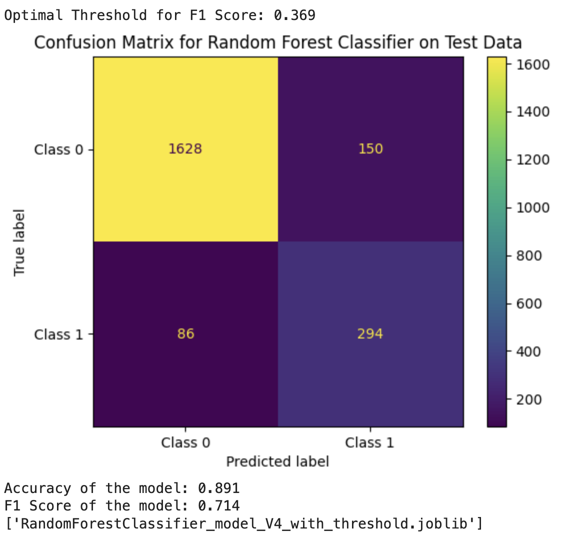

Best model for driver finishing position prediction:

Evaluation metric: Accuracy

Random Forest Classifier (max depth = 10, number of estimators = 100)

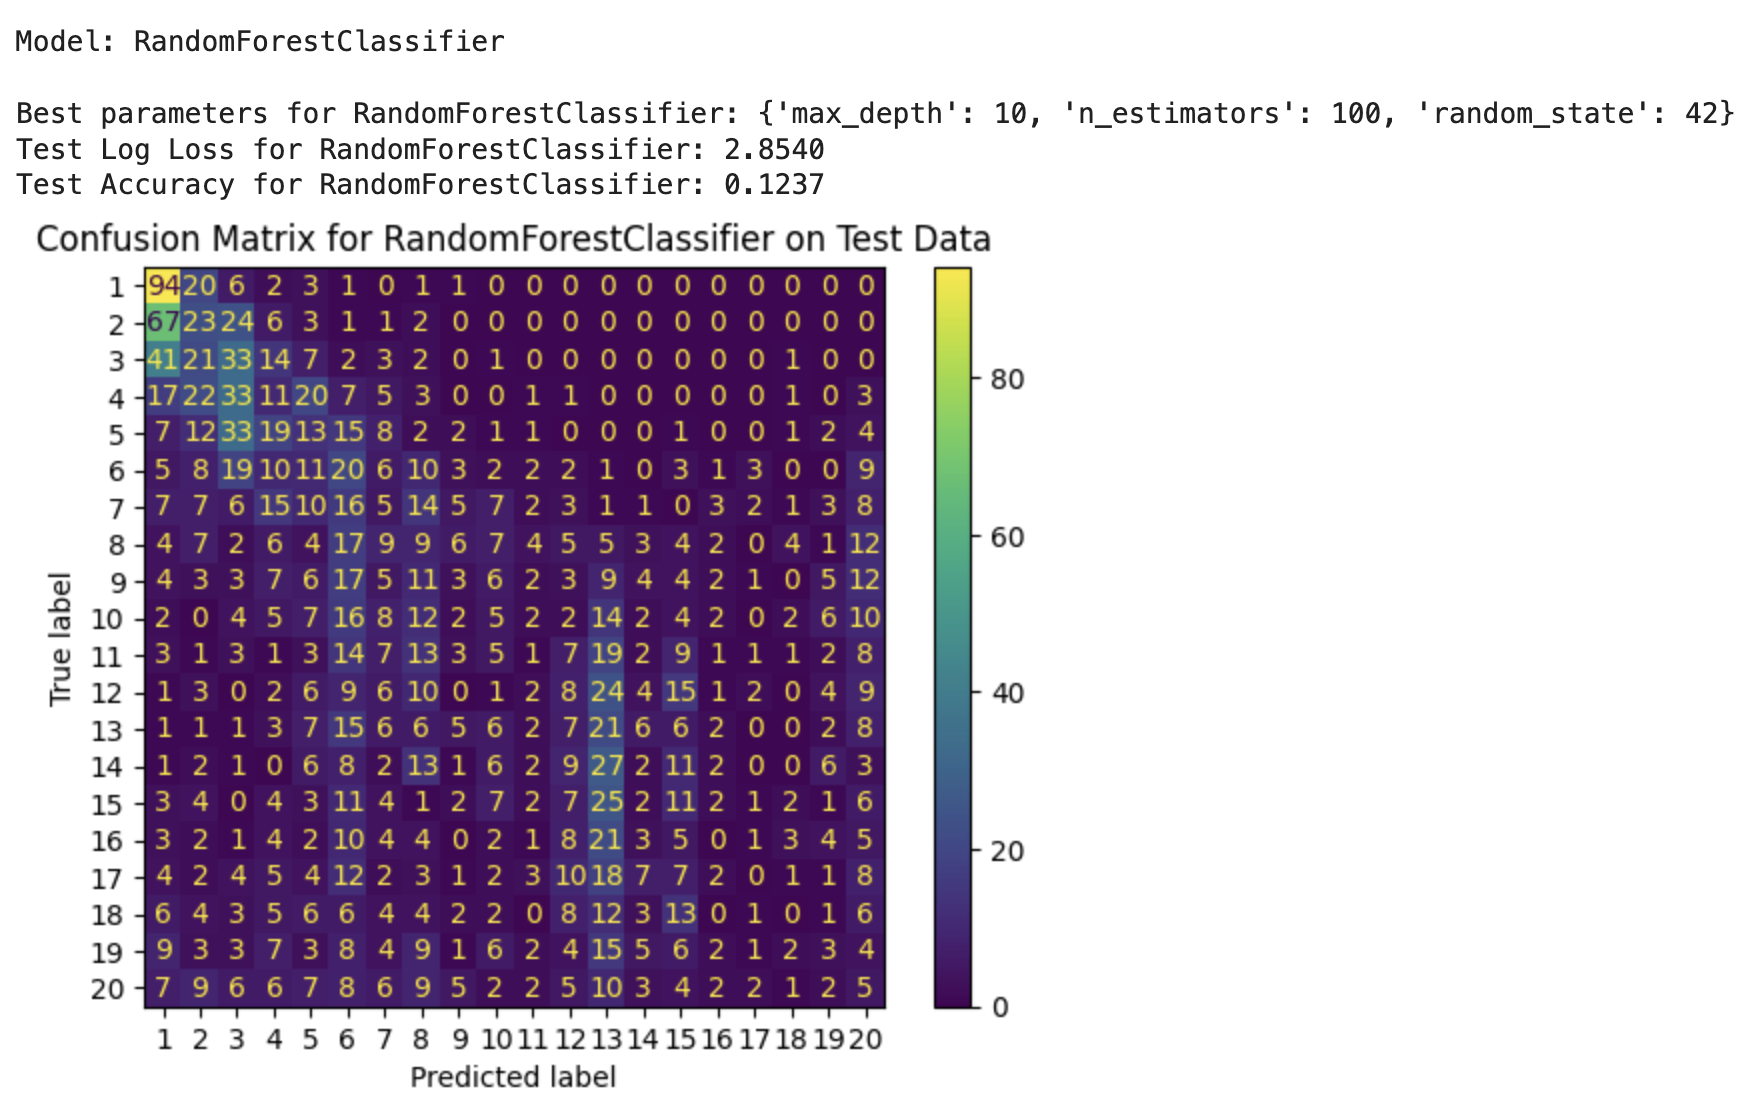

# Loading data

In [1]:
import pandas as pd

folder_path = './Data/'

# ID of constructors
constructors_df = pd.read_csv(folder_path + 'constructors.csv')

# ID of drivers
drivers_df = pd.read_csv(folder_path + 'drivers.csv')

# ID of each race
races = pd.read_csv(folder_path + 'races.csv')

# Starting grid and final position of every driver in every race (also includes status of each race)
results_df = pd.read_csv(folder_path + 'results.csv')

In [2]:
pd.get_option("display.max_columns",None)
print(results_df)

       resultId  raceId  driverId  constructorId number  grid position  \
0             1      18         1              1     22     1        1   
1             2      18         2              2      3     5        2   
2             3      18         3              3      7     7        3   
3             4      18         4              4      5    11        4   
4             5      18         5              1     23     3        5   
...         ...     ...       ...            ...    ...   ...      ...   
26514     26520    1132       839            214     31    18       16   
26515     26521    1132       815              9     11     0       17   
26516     26522    1132       855             15     24    14       18   
26517     26523    1132       847            131     63     1       \N   
26518     26524    1132       842            214     10    19       \N   

      positionText  positionOrder  points  laps         time milliseconds  \
0                1              1 

In [3]:
print(results_df.columns)

# Extract only relevant information about the race for training purposes
race_df = races[["raceId", "year", "round", "circuitId"]].copy()

Index(['resultId', 'raceId', 'driverId', 'constructorId', 'number', 'grid',
       'position', 'positionText', 'positionOrder', 'points', 'laps', 'time',
       'milliseconds', 'fastestLap', 'rank', 'fastestLapTime',
       'fastestLapSpeed', 'statusId'],
      dtype='object')


# EDA and Preprocessing


In [4]:
import pandas as pd
import matplotlib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier

In [ ]:
# Starting grid and final position of every driver, constructor in every race (also includes status of each race)
print("Driver result of a race")
print(results_df.head())

print("Race_df dataframe")
print(race_df.head())

Driver result of a race
   resultId  raceId  driverId  constructorId number  grid position  \
0         1      18         1              1     22     1        1   
1         2      18         2              2      3     5        2   
2         3      18         3              3      7     7        3   
3         4      18         4              4      5    11        4   
4         5      18         5              1     23     3        5   

  positionText  positionOrder  points  laps         time milliseconds  \
0            1              1    10.0    58  1:34:50.616      5690616   
1            2              2     8.0    58       +5.478      5696094   
2            3              3     6.0    58       +8.163      5698779   
3            4              4     5.0    58      +17.181      5707797   
4            5              5     4.0    58      +18.014      5708630   

  fastestLap rank fastestLapTime fastestLapSpeed  statusId  
0         39    2       1:27.452         218.300       

Now we sort our data by year, and only use data after 1982. This is because before 1981, the cars in F1 are drastically different from today.

In [ ]:
# After obtaining all relevant information about the race, we can get rid of the raceId variable
race_df = race_df.sort_values(by=['year', 'round'])

race_df = race_df[race_df["year"] >= 1982]

print(race_df)

      raceId  year  round  circuitId
466      467  1982      1         30
467      468  1982      2         36
468      469  1982      3         43
469      470  1982      4         21
470      471  1982      5         40
...      ...   ...    ...        ...
1120    1140  2024     20         32
1121    1141  2024     21         18
1122    1142  2024     22         80
1123    1143  2024     23         78
1124    1144  2024     24         24

[768 rows x 4 columns]


Select features from the original dataframe: raceId, driverId, constructorId, grid (starting postion), positionOrder (finishing position)

In [7]:
res_df = results_df[['raceId', 'driverId', 'constructorId', 'grid', 'positionOrder']].copy()
print(res_df)
duplicates = race_df.duplicated()
num_duplicates = duplicates.sum()
print(f"Number of duplicate rows: {num_duplicates}")
print(race_df)


       raceId  driverId  constructorId  grid  positionOrder
0          18         1              1     1              1
1          18         2              2     5              2
2          18         3              3     7              3
3          18         4              4    11              4
4          18         5              1     3              5
...       ...       ...            ...   ...            ...
26514    1132       839            214    18             16
26515    1132       815              9     0             17
26516    1132       855             15    14             18
26517    1132       847            131     1             19
26518    1132       842            214    19             20

[26519 rows x 5 columns]
Number of duplicate rows: 0
      raceId  year  round  circuitId
466      467  1982      1         30
467      468  1982      2         36
468      469  1982      3         43
469      470  1982      4         21
470      471  1982      5         40
... 

We want to merge the two datasets, so that we would have information about the year, the round, and the circuit for a specific race. We checked that we have no duplicate raceId, so we can proceed with merging the two datasets.

In [8]:
df = pd.merge(race_df, res_df, on='raceId')
print(df)

       raceId  year  round  circuitId  driverId  constructorId  grid  \
0         467  1982      1         30       117              4     5   
1         467  1982      1         30       199              3     8   
2         467  1982      1         30       163              4     1   
3         467  1982      1         30       182              1    13   
4         467  1982      1         30       177              3     7   
...       ...   ...    ...        ...       ...            ...   ...   
17755    1132  2024     12          9       839            214    18   
17756    1132  2024     12          9       815              9     0   
17757    1132  2024     12          9       855             15    14   
17758    1132  2024     12          9       847            131     1   
17759    1132  2024     12          9       842            214    19   

       positionOrder  
0                  1  
1                  2  
2                  3  
3                  4  
4                  5

In [9]:
df = pd.merge(race_df, res_df, on='raceId')
print(df.columns)

Index(['raceId', 'year', 'round', 'circuitId', 'driverId', 'constructorId',
       'grid', 'positionOrder'],
      dtype='object')


In [10]:
df.dtypes
df.isna().sum()

raceId           0
year             0
round            0
circuitId        0
driverId         0
constructorId    0
grid             0
positionOrder    0
dtype: int64

Summary Statistics for our dataframe:

In [11]:
# summary
df.describe().T

,count,mean,std,min,25%,50%,75%,max
raceId,17760.0,493.366441,359.325852,1.0,211.0,369.0,897.0,1132.0
year,17760.0,2002.366441,12.562293,1982.0,1991.0,2002.0,2013.0,2024.0
round,17760.0,9.296847,5.226795,1.0,5.0,9.0,14.0,22.0
circuitId,17760.0,20.035360,18.222480,1.0,8.0,14.0,25.0,80.0
driverId,17760.0,238.256419,316.684750,1.0,23.0,95.0,178.0,860.0
constructorId,17760.0,37.092005,57.144685,1.0,6.0,17.0,33.0,215.0
grid,17760.0,11.246227,7.016773,0.0,5.0,11.0,17.0,29.0
positionOrder,17760.0,12.660698,7.574587,1.0,6.0,12.0,18.0,39.0


Bar plot for number of F1 races by year:

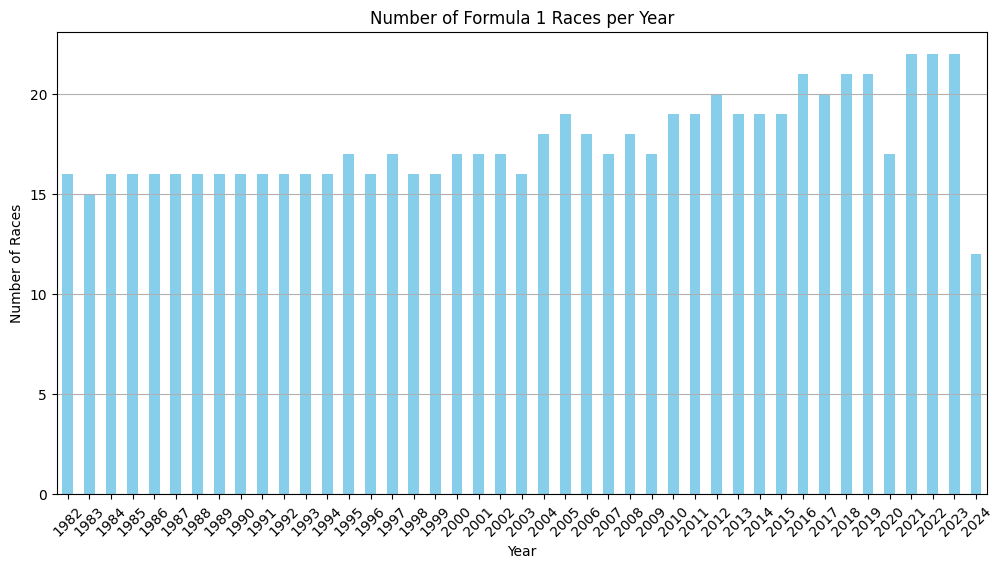

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your DataFrame
# Group data by 'year' and count the number of races
races_per_year = df.groupby('year')['raceId'].nunique()

# Create a bar plot
plt.figure(figsize=(12, 6))  # You can adjust the size as per your preference
races_per_year.plot(kind='bar', color='skyblue')

plt.title('Number of Formula 1 Races per Year')
plt.xlabel('Year')
plt.ylabel('Number of Races')
plt.xticks(rotation=45)  # Rotates the x-axis labels for better readability
plt.grid(axis='y')

# Display the plot
plt.show()

Plot top 15 Formula 1 Teams by Number of Races since 1982

In [13]:
races_per_team = df.groupby('constructorId')['raceId'].nunique()
races_per_team.head(10)


constructorId
1     755
2      70
3     755
4     340
5     268
6     756
7     140
8      39
9     382
10    212
Name: raceId, dtype: int64

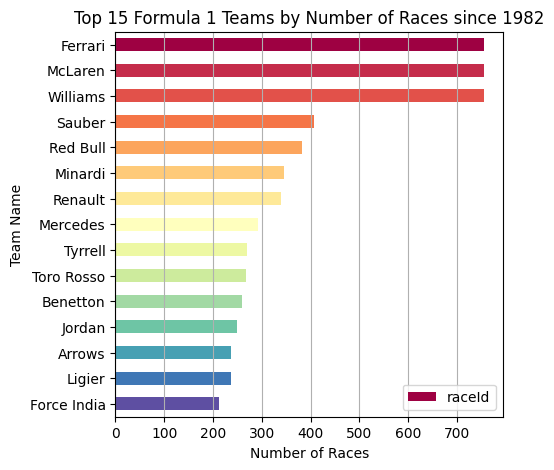

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Group data by 'constructorId' and count unique races
races_per_team = df.groupby('constructorId')['raceId'].nunique()

# Create a dictionary to map 'constructorId' to 'name'
constructor_name_dict = pd.Series(constructors_df.name.values, index=constructors_df.constructorId).to_dict()

# Replace 'constructorId' with corresponding 'name' in races_per_team
races_per_team.index = races_per_team.index.map(constructor_name_dict)

# Sort the data from most races to least races and select top 15
races_per_team_sorted = races_per_team.sort_values(ascending=False).head(15)

# Create a bar plot
plt.figure(figsize=(5,5))  # Adjust the figure size to your preference
colors = plt.cm.Spectral(np.linspace(0, 1, len(races_per_team_sorted))) # Using Spectral colormap
races_per_team_sorted.plot(kind='barh', color=colors)

plt.title('Top 15 Formula 1 Teams by Number of Races since 1982')
plt.ylabel('Team Name')
plt.xlabel('Number of Races')
plt.grid(axis='x')
plt.legend()

# Reverse the order of the y-axis so the team with most races is on top
plt.gca().invert_yaxis()

# Display the plot
plt.show()

In [15]:
driversTotalRaces = df.groupby('driverId')['raceId'].nunique()
print(driversTotalRaces[driversTotalRaces > 300])
print("Name:",driversTotalRaces.name)


driverId
1     344
4     392
8     352
18    309
22    326
30    308
Name: raceId, dtype: int64
Name: raceId


Plot top 15 Formula 1 Drivers by Number of Races since 1982

In [16]:
races_per_team = df.groupby('driverId')['raceId'].nunique()

races_per_team

driverId
1      344
2      184
3      206
4      392
5      112
      ... 
856     11
857     34
858     33
859      5
860      1
Name: raceId, Length: 264, dtype: int64

In [17]:
driversName = drivers_df.forename.values + " " + drivers_df.surname.values  # Combine 'forename' and 'surname' to get full name
driverID = drivers_df.driverId # Get 'driverId' to use as index

driver_name_dict = pd.Series(driversName, index=driverID).to_dict()
driver_name_dict

{1: 'Lewis Hamilton',
 2: 'Nick Heidfeld',
 3: 'Nico Rosberg',
 4: 'Fernando Alonso',
 5: 'Heikki Kovalainen',
 6: 'Kazuki Nakajima',
 7: 'Sébastien Bourdais',
 8: 'Kimi Räikkönen',
 9: 'Robert Kubica',
 10: 'Timo Glock',
 11: 'Takuma Sato',
 12: 'Nelson Piquet Jr.',
 13: 'Felipe Massa',
 14: 'David Coulthard',
 15: 'Jarno Trulli',
 16: 'Adrian Sutil',
 17: 'Mark Webber',
 18: 'Jenson Button',
 19: 'Anthony Davidson',
 20: 'Sebastian Vettel',
 21: 'Giancarlo Fisichella',
 22: 'Rubens Barrichello',
 23: 'Ralf Schumacher',
 24: 'Vitantonio Liuzzi',
 25: 'Alexander Wurz',
 26: 'Scott Speed',
 27: 'Christijan Albers',
 28: 'Markus Winkelhock',
 29: 'Sakon Yamamoto',
 30: 'Michael Schumacher',
 31: 'Juan Pablo Montoya',
 32: 'Christian Klien',
 33: 'Tiago Monteiro',
 34: 'Yuji Ide',
 35: 'Jacques Villeneuve',
 36: 'Franck Montagny',
 37: 'Pedro de la Rosa',
 38: 'Robert Doornbos',
 39: 'Narain Karthikeyan',
 40: 'Patrick Friesacher',
 41: 'Ricardo Zonta',
 42: 'Antônio Pizzonia',
 43: 'Cris

In [18]:
races_per_team.index = races_per_team.index.map(driver_name_dict)
races_per_team

driverId
Lewis Hamilton       344
Nick Heidfeld        184
Nico Rosberg         206
Fernando Alonso      392
Heikki Kovalainen    112
                    ... 
Nyck de Vries         11
Oscar Piastri         34
Logan Sargeant        33
Liam Lawson            5
Oliver Bearman         1
Name: raceId, Length: 264, dtype: int64

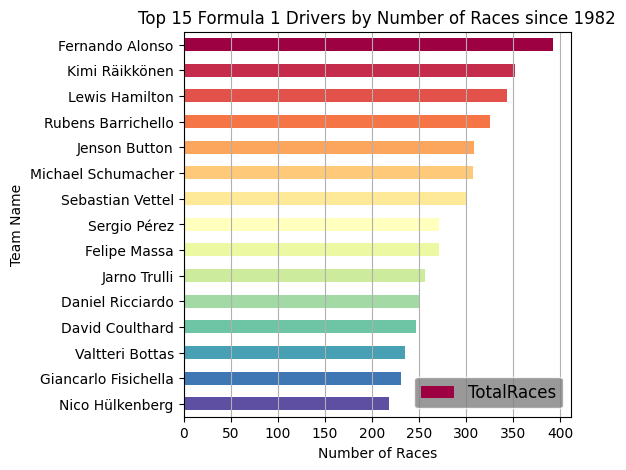

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Group data by 'driverId' and count unique races
races_per_team = df.groupby('driverId')['raceId'].nunique()

# Create a dictionary to map 'driverId' to 'name'

driversName = drivers_df.forename.values + " " + drivers_df.surname.values  # Combine 'forename' and 'surname' to get full name
driverID = drivers_df.driverId # Get 'driverId' to use as index

driver_name_dict = pd.Series(driversName, index=driverID).to_dict()

# Replace 'driverId' with corresponding 'name' in races_per_team
races_per_team.index = races_per_team.index.map(driver_name_dict)

# Sort the data from most races to least races and select top 15
races_per_team_sorted = races_per_team.sort_values(ascending=False)
races_per_team_sorted = races_per_team_sorted.head(15)

# Create a bar plot
plt.figure(figsize=(5, 5))  # Adjust the figure size to your preference
colors = plt.cm.Spectral(np.linspace(0, 1, len(races_per_team_sorted))) # Using Spectral colormap
races_per_team_sorted.plot(kind='barh', color=colors)

plt.title('Top 15 Formula 1 Drivers by Number of Races since 1982')
plt.ylabel('Team Name')
plt.xlabel('Number of Races')
plt.grid(axis='x')
plt.legend(['TotalRaces', 'Teams'], loc='lower right', fontsize='large', frameon=True, facecolor='grey', edgecolor='white')

# Reverse the order of the y-axis so the team with most races is on top
plt.gca().invert_yaxis()

# Display the plot
plt.show()

Plot histograms of starting and finishing positions:

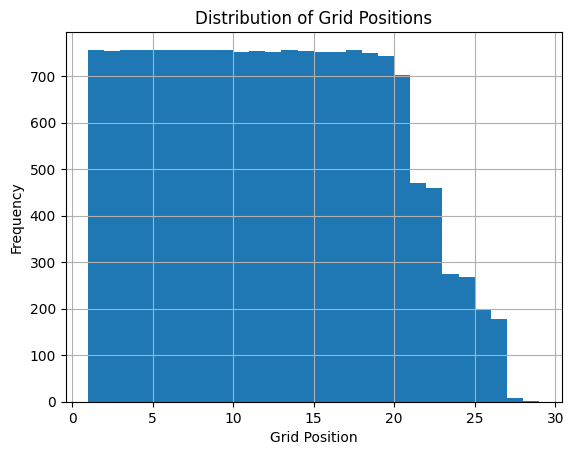

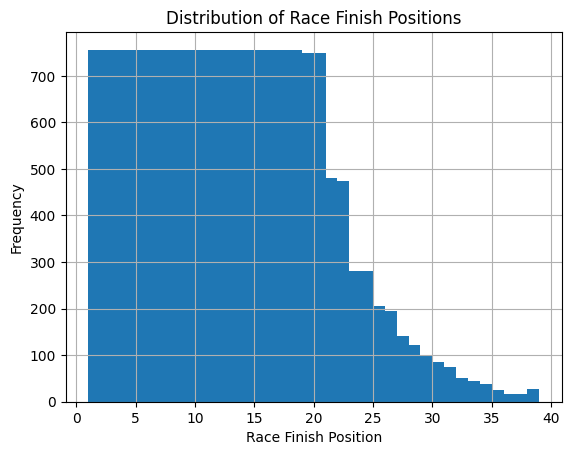

In [20]:
# Histogram of grid positions
df_nonZero = df[df['grid']!=0]
df_nonZero['grid'].hist(bins=28)
plt.title('Distribution of Grid Positions')
plt.xlabel('Grid Position')
plt.ylabel('Frequency')
plt.show()

# Histogram of positionOrder
df['positionOrder'].hist(bins=38)
plt.title('Distribution of Race Finish Positions')
plt.xlabel('Race Finish Position')
plt.ylabel('Frequency')
plt.show()


# Feature Engineering

## "Top 3 Finish": Add Target Variable

First we use an additional feature "Top 3 Finish" to specify whether a driver has finished in the top 3 for every race.

In [21]:
print(df.columns)
print


Index(['raceId', 'year', 'round', 'circuitId', 'driverId', 'constructorId',
       'grid', 'positionOrder'],
      dtype='object')


<function print(*args, sep=' ', end='\n', file=None, flush=False)>

In [22]:
# Creating a column for Top 3 Finish
df['Top 3 Finish'] = df['positionOrder'].le(3).astype(int)

# Display the first few rows to confirm the new column
print(df)

# To confirm we have the correct data
numberRace = df["raceId"].nunique()
print(f"Number of unique drivers: {numberRace}")

       raceId  year  round  circuitId  driverId  constructorId  grid  \
0         467  1982      1         30       117              4     5   
1         467  1982      1         30       199              3     8   
2         467  1982      1         30       163              4     1   
3         467  1982      1         30       182              1    13   
4         467  1982      1         30       177              3     7   
...       ...   ...    ...        ...       ...            ...   ...   
17755    1132  2024     12          9       839            214    18   
17756    1132  2024     12          9       815              9     0   
17757    1132  2024     12          9       855             15    14   
17758    1132  2024     12          9       847            131     1   
17759    1132  2024     12          9       842            214    19   

       positionOrder  Top 3 Finish  
0                  1             1  
1                  2             1  
2                  3    

## Past Performance Features: percentange of finishing in top 3
Driver:
1.   % of top 3 finishes last year
2.   % of top 3 finishes this year up till previous race

Constructor:
1.   % of top 3 finishes last year
2.   % of top 3 finishes this year up till previous race



Next, we want to find a way to measure past performance to predict future race result. One way of doing this is to find each driver and each team's percentage of finishing in the top 3 for last year and this year up till previous race. It's important that for current year, we only use data before current race (avoid data leakage)

Note that the round of the race also matters, since it tells us how much relevant data we have for the current year.

When we are calculating percentage for last year, we need to shift the 'year' feature by 1.  

### Driver: Percentage of finishing in top 3 for **past year**

In [23]:
# Calculating the total number of races and top 3 finishes for each driver in each year
driver_yearly_stats = df.groupby(['year', 'driverId']).agg(
    Total_Races=('raceId', 'nunique'),
    Top_3_Finishes=('Top 3 Finish', 'sum')
).reset_index()

print("Driver annual stats")
print(driver_yearly_stats)

# Calculating the percentage of top 3 finishes for each driver in each year
driver_yearly_stats['Driver Top 3 Finish Percentage (This Year)'] = (driver_yearly_stats['Top_3_Finishes'] / driver_yearly_stats['Total_Races']) * 100

# Shifting the driver percentages to the next year for last year's data
driver_last_year_stats = driver_yearly_stats.copy()
driver_last_year_stats['year'] += 1
driver_last_year_stats = driver_last_year_stats.rename(columns={'Driver Top 3 Finish Percentage (This Year)': 'Driver Top 3 Finish Percentage (Last Year)'})

df = pd.merge(df, driver_last_year_stats[['year', 'driverId', 'Driver Top 3 Finish Percentage (Last Year)']], on=['year', 'driverId'], how='left')

# Checking the merged data
print("New dataframe")
print(df[df["year"]>=1983])

Driver annual stats
      year  driverId  Total_Races  Top_3_Finishes
0     1982        90            1               0
1     1982        95           13               1
2     1982       105           16               2
3     1982       110           16               1
4     1982       117           16               4
...    ...       ...          ...             ...
1216  2024       852           12               0
1217  2024       855           12               0
1218  2024       857           12               2
1219  2024       858           11               0
1220  2024       860            1               0

[1221 rows x 4 columns]
New dataframe
       raceId  year  round  circuitId  driverId  constructorId  grid  \
465       452  1983      1         36       137             34     4   
466       452  1983      1         36       182              1     9   
467       452  1983      1         36       172              3    18   
468       452  1983      1         36       175      

In [24]:
print(df[df["year"]>=1982])

       raceId  year  round  circuitId  driverId  constructorId  grid  \
0         467  1982      1         30       117              4     5   
1         467  1982      1         30       199              3     8   
2         467  1982      1         30       163              4     1   
3         467  1982      1         30       182              1    13   
4         467  1982      1         30       177              3     7   
...       ...   ...    ...        ...       ...            ...   ...   
17755    1132  2024     12          9       839            214    18   
17756    1132  2024     12          9       815              9     0   
17757    1132  2024     12          9       855             15    14   
17758    1132  2024     12          9       847            131     1   
17759    1132  2024     12          9       842            214    19   

       positionOrder  Top 3 Finish  Driver Top 3 Finish Percentage (Last Year)  
0                  1             1                    

From our data, we can see that the value of "Top 3 Finish Last Year" is NaN for all data in 1982. This is because our dataframe only contains data after 1982, so there will be no last year performance to evaluate from when we are considering the races in 1982. When training our model, we will only train on data after 1983.

Furthermore, the value of "Top 3 Finish Last Year" is also NaN when this driver or team did not participate in F1 last year.

### Constructor(Team): Percentage of finishing in top 3 for **past year**

Here constructor percentage of finishing in top 3 means the average percentage of this team's drivers finishing in top 3.

In [25]:
# Calculating mean of top 3 finishes percentages for the two drivers in each constructor last year
constructor_last_year_stats = df.groupby(['year', 'constructorId', 'round']).agg(
    Sum_Top_3_Finishes_Last_Year=('Driver Top 3 Finish Percentage (Last Year)', 'sum')
).reset_index()

print("Constructor annual stats")
print(constructor_last_year_stats)

# Calculating the percentage of top 3 finishes for each constructor last year
constructor_last_year_stats['Constructor Top 3 Finish Percentage (Last Year)'] = constructor_last_year_stats["Sum_Top_3_Finishes_Last_Year"]/2

df = pd.merge(df, constructor_last_year_stats[['year', 'constructorId', 'round', 'Constructor Top 3 Finish Percentage (Last Year)']], on=['year', 'constructorId', 'round'], how='left')

# Checking the merged data
print("New dataframe")
print(df[df["year"]>=1983])

Constructor annual stats
      year  constructorId  round  Sum_Top_3_Finishes_Last_Year
0     1982              1      1                           0.0
1     1982              1      2                           0.0
2     1982              1      3                           0.0
3     1982              1      5                           0.0
4     1982              1      6                           0.0
...    ...            ...    ...                           ...
9098  2024            215      8                           0.0
9099  2024            215      9                           0.0
9100  2024            215     10                           0.0
9101  2024            215     11                           0.0
9102  2024            215     12                           0.0

[9103 rows x 4 columns]
New dataframe
       raceId  year  round  circuitId  driverId  constructorId  grid  \
465       452  1983      1         36       137             34     4   
466       452  1983      1         3

### Driver: Percentage of finishing in top 3 for **current year** till last race

In [26]:
# Creating a function to calculate the top 3 finish percentage before the current round for drivers
def calculate_driver_top_3_percentage_before_round(row, df):
    # Filter for races in the same year, for the same driver, but in earlier rounds
    previous_races = df[(df['year'] == row['year']) & (df['driverId'] == row['driverId']) & (df['round'] < row['round'])]
    if len(previous_races) == 0:
      return pd.NA

    total_races = previous_races['raceId'].nunique()
    top_3_finishes = previous_races['Top 3 Finish'].sum()

    # Calculate the percentage
    return (top_3_finishes / total_races) * 100 if total_races > 0 else pd.NA

# Apply the function to each row in the DataFrame
df['Driver Top 3 Finish Percentage (This Year till last race)'] = df.apply(lambda row: calculate_driver_top_3_percentage_before_round(row, df), axis=1)


### Constructor(Team): Percentage of finishing in top 3 for **current year** till last race

In [27]:
# Calculating mean of top 3 finishes percentages for the two drivers in each constructor this year
constructor_this_year_stats = df.groupby(['year', 'constructorId', 'round']).agg(
    Sum_Top_3_Finishes_This_Year=('Driver Top 3 Finish Percentage (This Year till last race)', 'sum')
).reset_index()

print("Constructor annual stats")
print(constructor_this_year_stats)

# Calculating the percentage of top 3 finishes for each constructor this year
constructor_this_year_stats['Constructor Top 3 Finish Percentage (This Year till last race)'] = constructor_this_year_stats["Sum_Top_3_Finishes_This_Year"]/2

df = pd.merge(df, constructor_this_year_stats[['year', 'constructorId', 'round', 'Constructor Top 3 Finish Percentage (This Year till last race)']], on=['year', 'constructorId', 'round'], how='left')

# Checking the merged data
print("New dataframe")
print(df[df["year"]>=1983])

Constructor annual stats
      year  constructorId  round Sum_Top_3_Finishes_This_Year
0     1982              1      1                            0
1     1982              1      2                          0.0
2     1982              1      3                         50.0
3     1982              1      5                    66.666667
4     1982              1      6                         75.0
...    ...            ...    ...                          ...
9098  2024            215      8                          0.0
9099  2024            215      9                          0.0
9100  2024            215     10                          0.0
9101  2024            215     11                          0.0
9102  2024            215     12                          0.0

[9103 rows x 4 columns]
New dataframe
       raceId  year  round  circuitId  driverId  constructorId  grid  \
465       452  1983      1         36       137             34     4   
466       452  1983      1         36       182 

## Past Performance Features: Average Finishing position

### Driver: Average finishing position for **past year**

In [28]:
year_based_results = df.groupby(['year', 'driverId'])
print(year_based_results)

In [29]:
# Calculating the total number of races and top 3 finishes for each driver in each year
driver_yearly_stats = df.groupby(['year', 'driverId']).agg(
    Total_Races=('raceId', 'nunique'),
    Avg_position=('positionOrder', 'mean')
).reset_index()

print("Driver annual stats")
print(driver_yearly_stats)
 
# Calculating the percentage of top 3 finishes for each driver in each year
driver_yearly_stats['Driver Avg position (This Year)'] = driver_yearly_stats['Avg_position']

# Shifting the driver percentages to the next year for last year's data
driver_last_year_stats = driver_yearly_stats.copy()
driver_last_year_stats['year'] += 1
driver_last_year_stats = driver_last_year_stats.rename(columns={'Driver Avg position (This Year)': 'Driver Avg position (Last Year)'})

df = pd.merge(df, driver_last_year_stats[['year', 'driverId', 'Driver Avg position (Last Year)']], on=['year', 'driverId'], how='left')

# Checking the merged data
print("New dataframe")
print(df[df["year"]>=1983])

Driver annual stats
      year  driverId  Total_Races  Avg_position
0     1982        90            1     30.000000
1     1982        95           13     13.692308
2     1982       105           16      9.000000
3     1982       110           16     14.437500
4     1982       117           16     10.000000
...    ...       ...          ...           ...
1216  2024       852           12     12.250000
1217  2024       855           12     15.333333
1218  2024       857           12      5.750000
1219  2024       858           11     17.272727
1220  2024       860            1      7.000000

[1221 rows x 4 columns]
New dataframe
       raceId  year  round  circuitId  driverId  constructorId  grid  \
465       452  1983      1         36       137             34     4   
466       452  1983      1         36       182              1     9   
467       452  1983      1         36       172              3    18   
468       452  1983      1         36       175              6     3   
469  

### Constructor(Team): Average finishing position for **past year**

Here constructor average finishing postion means the average finishing position of both drivers in the constructor(team).

In [30]:
# Calculating mean of top 3 finishes percentages for the two drivers in each constructor last year
constructor_last_year_stats = df.groupby(['year', 'constructorId', 'round']).agg(
    sum_position_last_year=('Driver Avg position (Last Year)', 'sum')
).reset_index()

print("Constructor annual stats")
print(constructor_last_year_stats)

# Calculating the percentage of top 3 finishes for each constructor last year
constructor_last_year_stats['Constructor Avg position (Last Year)'] = constructor_last_year_stats["sum_position_last_year"]/2

df = pd.merge(df, constructor_last_year_stats[['year', 'constructorId', 'round', 'Constructor Avg position (Last Year)']], on=['year', 'constructorId', 'round'], how='left')

# Checking the merged data
print("New dataframe")
print(df[df["year"]>=1983])

Constructor annual stats
      year  constructorId  round  sum_position_last_year
0     1982              1      1                0.000000
1     1982              1      2                0.000000
2     1982              1      3                0.000000
3     1982              1      5                0.000000
4     1982              1      6                0.000000
...    ...            ...    ...                     ...
9098  2024            215      8               25.896104
9099  2024            215      9               25.896104
9100  2024            215     10               25.896104
9101  2024            215     11               25.896104
9102  2024            215     12               25.896104

[9103 rows x 4 columns]
New dataframe
       raceId  year  round  circuitId  driverId  constructorId  grid  \
465       452  1983      1         36       137             34     4   
466       452  1983      1         36       182              1     9   
467       452  1983      1         3

### Driver: Average finishing position for **current year** till last race

In [31]:
def calculate_driver_avg_position_before_round(row, df):
    # Filter for races in the same year, for the same driver, but in earlier rounds
    previous_races = df[(df['year'] == row['year']) & (df['driverId'] == row['driverId']) & (df['round'] < row['round'])]
    if len(previous_races) == 0:
      return pd.NA
    # Calculate the total races and sum of positions
    total_races = previous_races['raceId'].nunique()
    positionSum = previous_races['positionOrder'].sum()

    # Calculate average position
    return (positionSum / total_races) if total_races > 0 else pd.NA

# Apply the function to each row in the DataFrame
df['Driver Average Position (This Year till last race)'] = df.apply(lambda row: calculate_driver_avg_position_before_round(row, df), axis=1)


### Constructor(Team): Average finishing position for **current year** till last race

In [32]:
# Calculating mean of top 3 finishes percentages for the two drivers in each constructor this year
constructor_this_year_stats = df.groupby(['year', 'constructorId', 'round']).agg(
    sum_Position_Constructor = ('Driver Average Position (This Year till last race)', 'sum')
).reset_index()

print("Constructor annual stats")
print(constructor_this_year_stats)

# Calculating the percentage of top 3 finishes for each constructor this year
constructor_this_year_stats['Constructor Average Position (This Year till last race)'] = constructor_this_year_stats["sum_Position_Constructor"]/2

df = pd.merge(df, constructor_this_year_stats[['year', 'constructorId', 'round', 'Constructor Average Position (This Year till last race)']], on=['year', 'constructorId', 'round'], how='left')

# Checking the merged data
print("New dataframe")
print(df[df["year"]>=1983])

Constructor annual stats
      year  constructorId  round sum_Position_Constructor
0     1982              1      1                        0
1     1982              1      2                     10.0
2     1982              1      3                     14.5
3     1982              1      5                     12.0
4     1982              1      6                    11.75
...    ...            ...    ...                      ...
9098  2024            215      8                26.857143
9099  2024            215      9                     26.0
9100  2024            215     10                25.555556
9101  2024            215     11                     26.4
9102  2024            215     12                26.090909

[9103 rows x 4 columns]
New dataframe


       raceId  year  round  circuitId  driverId  constructorId  grid  \
465       452  1983      1         36       137             34     4   
466       452  1983      1         36       182              1     9   
467       452  1983      1         36       172              3    18   
468       452  1983      1         36       175              6     3   
469       452  1983      1         36       176             21    20   
...       ...   ...    ...        ...       ...            ...   ...   
17755    1132  2024     12          9       839            214    18   
17756    1132  2024     12          9       815              9     0   
17757    1132  2024     12          9       855             15    14   
17758    1132  2024     12          9       847            131     1   
17759    1132  2024     12          9       842            214    19   

       positionOrder  Top 3 Finish  \
465                1             1   
466                2             1   
467                3 

Checking data from 2023 to make sure everything's correct

In [33]:
print(df[(df["year"] == 2023)& (df["round"] > 3) ].head(30))

       raceId  year  round  circuitId  driverId  constructorId  grid  \
17141    1101  2023      4         73       815              9     3   
17142    1101  2023      4         73       830              9     2   
17143    1101  2023      4         73       844              6     1   
17144    1101  2023      4         73         4            117     6   
17145    1101  2023      4         73       832              6     4   
17146    1101  2023      4         73         1            131     5   
17147    1101  2023      4         73       840            117     9   
17148    1101  2023      4         73       847            131    11   
17149    1101  2023      4         73       846              1     7   
17150    1101  2023      4         73       852            213     8   
17151    1101  2023      4         73       857              1    10   
17152    1101  2023      4         73       848              3    12   
17153    1101  2023      4         73       825            210  

## Check dataframe


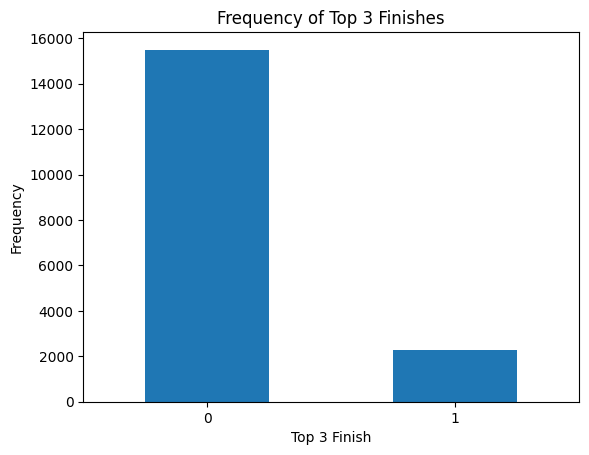

In [34]:
# Histogram for Top 3 Finishes
df['Top 3 Finish'].value_counts().plot(kind='bar')
plt.title('Frequency of Top 3 Finishes')
plt.xlabel('Top 3 Finish')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()

In [35]:
nan_counts = df.isna().sum()
print(nan_counts)

raceId                                                               0
year                                                                 0
round                                                                0
circuitId                                                            0
driverId                                                             0
constructorId                                                        0
grid                                                                 0
positionOrder                                                        0
Top 3 Finish                                                         0
Driver Top 3 Finish Percentage (Last Year)                        3704
Constructor Top 3 Finish Percentage (Last Year)                      0
Driver Top 3 Finish Percentage (This Year till last race)         1221
Constructor Top 3 Finish Percentage (This Year till last race)       0
Driver Avg position (Last Year)                                   3704
Constr

The NA in top 3 Finish Percentage Last Year represents that the driver did not participate in F1 last year. The NA in Driver Top 3 Finish Percentage (This Year till last race) represents that it is the first round of the year (so no previous data) or this is the first round that this driver is participating in that year.

# Feature Selection for training purpose


We drop information related to the result of this race (e.g. finishing position) from the dataframe to prevent data leakage

In [36]:
df_final = df.drop(labels=["raceId"], axis=1)

In [37]:
print("Number of rows in total:", df_final.shape[0])

# Count rows where 'year' is not 1982 before dropping NaN values
initial_count = len(df_final[df_final['year'] != 1982])

# Drop rows with NaN values
df_final = df_final.dropna()

# Count rows where 'year' is not 1982 after dropping NaN values
final_count = len(df_final[df_final['year'] != 1982])

# Calculate the number of rows dropped
rows_dropped = initial_count - final_count

print("Number of rows dropped where year is not 1982:", rows_dropped)
df_final_keepPositionOrder = df_final.copy()
df_final = df_final.drop(["positionOrder"], axis = 1)
print(df_final)

Number of rows in total: 17760
Number of rows dropped where year is not 1982: 4124
       year  round  circuitId  driverId  constructorId  grid  Top 3 Finish  \
493    1983      2         43       187              1    22             1   
494    1983      2         43       182              1    23             1   
495    1983      2         43       163              6     2             1   
496    1983      2         43       172              3     4             0   
497    1983      2         43       176             21    16             0   
...     ...    ...        ...       ...            ...   ...           ...   
17755  2024     12          9       839            214    18             0   
17756  2024     12          9       815              9     0             0   
17757  2024     12          9       855             15    14             0   
17758  2024     12          9       847            131     1             0   
17759  2024     12          9       842            214    1

Here we dropped 4078 rows out of 17321 rows that we have. Therefore, we will not have these data for our model prediction. Thus, a limitation of our model is that it cannot make prediction for drivers/teams that did not participate in the year before, and it cannot predict the first race of the year

# Exploratory Data Analysis

In [38]:
df_final["Driver Top 3 Finish Percentage (This Year till last race)"] = df_final["Driver Top 3 Finish Percentage (This Year till last race)"].astype(float)
df_final["Constructor Top 3 Finish Percentage (This Year till last race)"] = df_final["Constructor Top 3 Finish Percentage (This Year till last race)"].astype(float)
df_final["Driver Average Position (This Year till last race)"] = df_final["Driver Average Position (This Year till last race)"].astype(float)
df_final["Constructor Average Position (This Year till last race)"] = df_final["Constructor Average Position (This Year till last race)"].astype(float)

In [39]:
# Using describe() and selecting specific rows
description = df_final.describe()
selected_description = description.loc[['count', 'mean', 'std', 'min', 'max']]
# print(description)
print(selected_description)


               year         round     circuitId      driverId  constructorId  \
count  13171.000000  13171.000000  13171.000000  13171.000000   13171.000000   
mean    2003.073191      9.793638     20.221471    228.313416      35.559715   
std       12.461596      4.971300     18.387368    314.354383      56.317275   
min     1983.000000      2.000000      1.000000      1.000000       1.000000   
max     2024.000000     22.000000     80.000000    858.000000     215.000000   

               grid  Top 3 Finish  Driver Top 3 Finish Percentage (Last Year)  \
count  13171.000000  13171.000000                                13171.000000   
mean      10.470352      0.153064                                   14.962249   
std        6.694886      0.360062                                   22.648261   
min        0.000000      0.000000                                    0.000000   
max       29.000000      1.000000                                  100.000000   

       Constructor Top 3 Finish 

In [40]:

print(f"Column count {df_final.columns}")

Column count Index(['year', 'round', 'circuitId', 'driverId', 'constructorId', 'grid',
       'Top 3 Finish', 'Driver Top 3 Finish Percentage (Last Year)',
       'Constructor Top 3 Finish Percentage (Last Year)',
       'Driver Top 3 Finish Percentage (This Year till last race)',
       'Constructor Top 3 Finish Percentage (This Year till last race)',
       'Driver Avg position (Last Year)',
       'Constructor Avg position (Last Year)',
       'Driver Average Position (This Year till last race)',
       'Constructor Average Position (This Year till last race)'],
      dtype='object')


In [41]:
# df_final["Driver Top 3 Finish Percentage (Last Year)"]
driver_830_top_3_finishes = df_final[df_final['driverId'] == 830]
driverfinishes = driver_830_top_3_finishes.loc[:, ['year', 'round', 'Top 3 Finish', 'Driver Top 3 Finish Percentage (Last Year)']]
print(driverfinishes)

       year  round  Top 3 Finish  Driver Top 3 Finish Percentage (Last Year)
14186  2016      2             0                                    0.000000
14210  2016      3             0                                    0.000000
14243  2016      4             0                                    0.000000
14247  2016      5             1                                    0.000000
14286  2016      6             0                                    0.000000
...     ...    ...           ...                                         ...
17665  2024      8             0                                   95.454545
17680  2024      9             1                                   95.454545
17700  2024     10             1                                   95.454545
17724  2024     11             0                                   95.454545
17741  2024     12             1                                   95.454545

[169 rows x 4 columns]


In [42]:
print(f"Column count {df_final.shape[1]}")

Column count 15


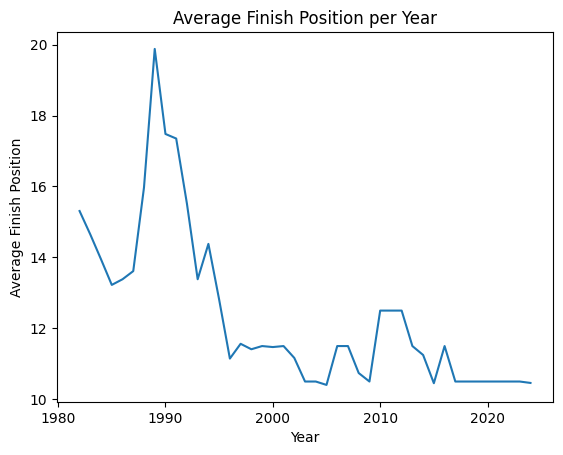

In [43]:
# Average finish position per year
avg_finish_per_year = df.groupby('year')['positionOrder'].mean()
avg_finish_per_year.plot(kind='line')
plt.title('Average Finish Position per Year')
plt.xlabel('Year')
plt.ylabel('Average Finish Position')
plt.show()


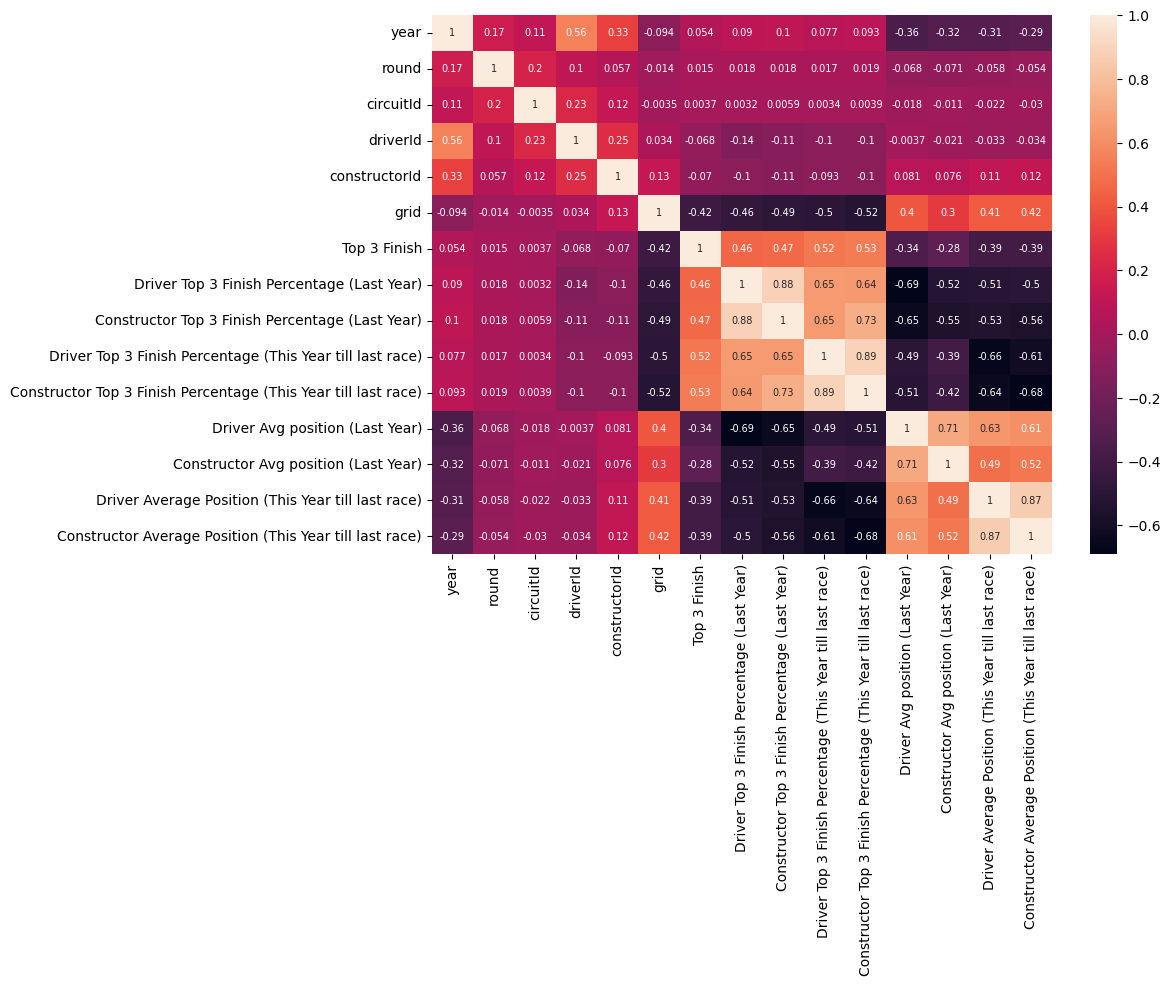

In [44]:
# heatmap
plt.figure(figsize=(10,7))
sns.heatmap(df_final.corr(), annot=True, mask = False, annot_kws={"size": 7})
plt.show()

We can see that the top 3 finish percentage for both drivers and constructors(teams) in the current and past year have strong positive correlations with the target variable `Top 3 Finish', which is whether the driver finishes in top 3 for this race. The values of these correlations are between 0.46 and 0.53.

In addition, grid (driver's starting position for this race) and average finishing positions for drivers and teams in the past and current year have negative correlations with the target variable `Top 3 Finish'. This is expected as when the starting position or average finishing position has a higher value, it's less likely for the car to finish in top 3.

Furthermore, several engineered features have some degree of correlations. For example, the correlation between 'Driver Top 3 Finish Percentage (Last Year)' and `Driver Top 3 Finish Percentage (This Year till last race)' is 0.65. But since they are not close to a perfect correlation, having an additional feature still has the potential to improve our classification model.

In [45]:
correlations = df_final.corr()['Top 3 Finish'].sort_values(ascending=False)

# Display
print(correlations)

Top 3 Finish                                                      1.000000
Constructor Top 3 Finish Percentage (This Year till last race)    0.531223
Driver Top 3 Finish Percentage (This Year till last race)         0.523979
Constructor Top 3 Finish Percentage (Last Year)                   0.465248
Driver Top 3 Finish Percentage (Last Year)                        0.457875
year                                                              0.053939
round                                                             0.014848
circuitId                                                         0.003733
driverId                                                         -0.068275
constructorId                                                    -0.070372
Constructor Avg position (Last Year)                             -0.276158
Driver Avg position (Last Year)                                  -0.340637
Driver Average Position (This Year till last race)               -0.387256
Constructor Average Posit

# One Hot Encoding

In [46]:
df_final_encoded = pd.get_dummies(df_final, columns=['circuitId', 'driverId', 'constructorId'])
df_final_encoded.shape[1]

316

In [47]:
df_final_encoded.to_csv('./Data/df_final_encoded.csv', index=False)

The provided code reorders the columns of the DataFrame df_final_encoded to move the column 'Top 3 Finish' to the end of the DataFrame. Let’s break it down step by step:

In [48]:
# Create a list of columns excluding the one to move
cols = [col for col in df_final_encoded.columns if col != 'Top 3 Finish']#This creates a new list, cols, containing all the column names in df_final_encoded except 'Top 3 Finish'.

# Append the column to the end of the DataFrame
df_final_encoded = df_final_encoded[cols + ['Top 3 Finish']]

print(df_final_encoded)
print(df_final_encoded.shape)

       year  round  grid  Driver Top 3 Finish Percentage (Last Year)  \
493    1983      2    22                                   33.333333   
494    1983      2    23                                   21.428571   
495    1983      2     2                                   25.000000   
496    1983      2     4                                    6.666667   
497    1983      2    16                                    0.000000   
...     ...    ...   ...                                         ...   
17755  2024     12    18                                    4.545455   
17756  2024     12     0                                   40.909091   
17757  2024     12    14                                    0.000000   
17758  2024     12     1                                    9.090909   
17759  2024     12    19                                    4.545455   

       Constructor Top 3 Finish Percentage (Last Year)  \
493                                          27.380952   
494                

# Data Science Models to predict F1 podiums

## Predicting F1 podiums without qualfying data

Trianing data: year 1983 - 2008

Validation data: year 2009 - 2016

Test data: year 2017 - 2023


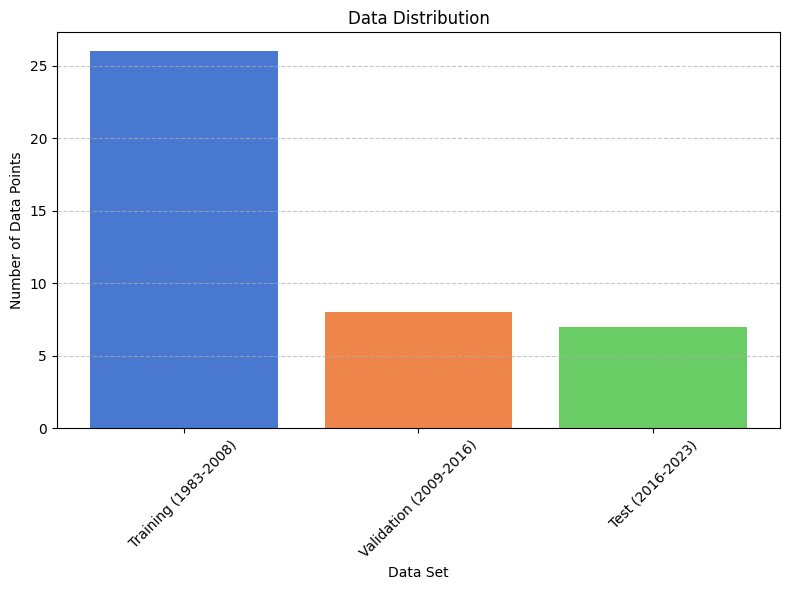

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Data for the bar chart
data = {
    'Training (1983-2008)': 26, 
    'Validation (2009-2016)': 8,
    'Test (2016-2023)': 7
}

# Extract labels and values
labels = list(data.keys())
values = list(data.values())

# Use a seaborn color palette for more visually appealing colors
colors = sns.color_palette("muted") 

# Create the bar chart
plt.figure(figsize=(8, 6))
plt.bar(labels, values, color=colors)

# Set labels and title
plt.xlabel('Data Set')
plt.ylabel('Number of Data Points')
plt.title('Data Distribution')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Customize appearance
plt.grid(axis='y', linestyle='--', alpha=0.7) 
plt.tight_layout()

# Show the plot
plt.show()

### Experiment 1: Features: Driver Top 3 Finish Percentage last year, Constructor Top 3 Finish Percentage last year

In Experiment 1, We start with the most simple model to see how the data science models perform. In this model, apart from year, round, circuit, constructor and race, we only consider two additional feature (the percentages of finishing in top 3 for the past year for drivers and for constructors).

#### Model Training and Assessment

In [49]:
print(df_final_encoded)

       year  round  grid  Driver Top 3 Finish Percentage (Last Year)  \
493    1983      2    22                                   33.333333   
494    1983      2    23                                   21.428571   
495    1983      2     2                                   25.000000   
496    1983      2     4                                    6.666667   
497    1983      2    16                                    0.000000   
...     ...    ...   ...                                         ...   
17755  2024     12    18                                    4.545455   
17756  2024     12     0                                   40.909091   
17757  2024     12    14                                    0.000000   
17758  2024     12     1                                    9.090909   
17759  2024     12    19                                    4.545455   

       Constructor Top 3 Finish Percentage (Last Year)  \
493                                          27.380952   
494                

In [50]:
df_1 = df_final_encoded.drop(["grid", "Driver Top 3 Finish Percentage (This Year till last race)", "Constructor Top 3 Finish Percentage (This Year till last race)", "Driver Average Position (This Year till last race)", "Constructor Average Position (This Year till last race)", "Driver Average Position (This Year till last race)", "Constructor Average Position (This Year till last race)"], axis = 1)


In [51]:
df_1

,year,round,Driver Top 3 Finish Percentage (Last Year),Constructor Top 3 Finish Percentage (Last Year),Driver Avg position (Last Year),Constructor Avg position (Last Year),circuitId_1,circuitId_2,circuitId_3,circuitId_4,...,constructorId_206,constructorId_207,constructorId_208,constructorId_209,constructorId_210,constructorId_211,constructorId_213,constructorId_214,constructorId_215,Top 3 Finish
493,1983,2,33.333333,27.380952,8.333333,8.845238,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
494,1983,2,21.428571,27.380952,9.357143,8.845238,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
495,1983,2,25.000000,31.250000,14.062500,11.593750,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
496,1983,2,6.666667,23.333333,16.466667,11.233333,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
497,1983,2,0.000000,0.000000,10.166667,5.083333,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17755,2024,12,4.545455,4.545455,11.863636,11.272727,False,False,False,False,...,False,False,False,False,False,False,False,True,False,0
17756,2024,12,40.909091,68.181818,5.863636,3.568182,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
17757,2024,12,0.000000,0.000000,14.045455,14.000000,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
17758,2024,12,9.090909,18.181818,8.090909,7.136364,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0


In [52]:
from sklearn.preprocessing import StandardScaler

train_df = df_1[(df_1["year"] >= 1983) & (df_1["year"] <= 2008)]
val_df = df_1[(df_1["year"] >= 2009) & (df_1["year"] <= 2016)]
test_df = df_1[(df_1["year"] >= 2017) & (df_1["year"] <= 2023)]

X_train = train_df[train_df.columns.tolist()[:-1]].values
y_train = train_df['Top 3 Finish'].values
X_val = val_df[train_df.columns.tolist()[:-1]].values
y_val = val_df['Top 3 Finish'].values
X_test = test_df[train_df.columns.tolist()[:-1]].values
y_test = test_df['Top 3 Finish'].values

##### Model Metrics
Since there is a class imbalance between those who finish in top 3 (only 3 drivers) and those who don't (17 or more), we use AUC-ROC score. I initially used Accuracy as the metric, but some models simply predict the majority class (not in top 3) too often to achieve high accuracy rate, but this leads to low value in Recall.

##### Model Fitting and assessment

In [ ]:
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, ConfusionMatrixDisplay  # Import f1_score
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

# Dictionary to store the best model and test accuracy for each algorithm
model_accuracy_info = {}

# Define the hyperparameter grid for each model
param_grid = {
    'LogisticRegression': {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'random_state': [42]},
    'KNeighborsClassifier': {'n_neighbors': [3, 5, 7, 10, 12, 13, 15, 20]},
    'SVC': {'C': [0.1, 1, 10], 'kernel': ['rbf', 'linear'], 'gamma': ['scale', 'auto'], 'random_state': [42], 'probability': [True]},
    'RandomForestClassifier': {'n_estimators': [10, 50, 100], 'max_depth': [None, 10, 20, 30], 'random_state': [42]},
    'DecisionTreeClassifier': {'max_depth': [None, 5, 10, 20], 'random_state': [42]},
    'GaussianNB': {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]}
}

# Initialize models
models = {
    'LogisticRegression': LogisticRegression(),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'SVC': SVC(),
    'RandomForestClassifier': RandomForestClassifier(),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'GaussianNB': GaussianNB(),
}

# Ignore convergence and future warnings
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)
simplefilter("ignore", category=FutureWarning)

# Function to manually tune hyperparameters
def tune_hyperparameters(model, params, X_train, y_train, X_val, y_val):
    best_model = None
    best_params = {}
    best_auc = 0  # Use AUC-ROC instead of F1 score
    for param in ParameterGrid(params):
        model.set_params(**param)
        model.fit(X_train, y_train)
        probabilities = model.predict_proba(X_val)
        auc = roc_auc_score(y_val, probabilities[:, 1])  # Calculate AUC-ROC
        if auc > best_auc:
            best_auc = auc
            best_model = model
            best_params = param
    return best_model, best_params

# Perform hyperparameter tuning and evaluation
for name, model in models.items():
    print(f"Model: {name}")
    if name in param_grid:
        # Tune hyperparameters
        best_model, best_params = tune_hyperparameters(model, param_grid[name], X_train, y_train, X_val, y_val)
        print(f"Best parameters for {name}: {best_params}")
        model = best_model

    # Predict and evaluate on test data using AUC-ROC
    pred_test = model.predict_proba(X_test)
    auc_test = roc_auc_score(y_test, pred_test[:, 1])  # Calculate AUC-ROC
    accuracy_test = accuracy_score(y_test, pred_test[:, 1] >= 0.5)  # Calculate accuracy

    print(f"Test AUC-ROC for {name}: {auc_test:.4f}\n")
    model_filename = f"{name}_model_V1.joblib"
    joblib.dump(model, model_filename)
    model_accuracy_info[name] = {
        'model': model_filename,
        'auc_roc': auc_test,  # Store AUC-ROC
        'accuracy': accuracy_test
    }

    # Calculate ROC curve and AUC for each model
    fpr, tpr, thresholds = roc_curve(y_test, pred_test[:, 1])
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.plot(fpr, tpr, label=f'{name} (area = {roc_auc:.2f})')

    # Print model and F1 score info
for model_name, info in model_accuracy_info.items():
    print(f"Model: {model_name}, File: {info['model']}, Test AUC-ROC: {info['auc_roc']:.4f}, Test Accuracy: {info['accuracy']:.4f}")

plt.plot([0, 1], [0, 1], 'k--')  # Add a diagonal dashed line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()



Model: LogisticRegression
Best parameters for LogisticRegression: {'C': 0.001, 'random_state': 42}
Test AUC-ROC for LogisticRegression: 0.7794

Model: KNeighborsClassifier
Best parameters for KNeighborsClassifier: {'n_neighbors': 20}
Test AUC-ROC for KNeighborsClassifier: 0.8251

Model: SVC


### Experiement 2: Now we add two more features: the percentages of finishing in top 3 for this year up till last race for drivers and for constructors.

#### Model Training and Assessment

In [41]:
df_2 = df_final_encoded.drop(["grid", "Driver Average Position (This Year till last race)", "Constructor Average Position (This Year till last race)", "Driver Average Position (This Year till last race)", "Constructor Average Position (This Year till last race)"], axis = 1)

In [42]:
from sklearn.preprocessing import StandardScaler

train_df = df_2[(df_2["year"] >= 1983) & (df_2["year"] <= 2008)]
val_df = df_2[(df_2["year"] >= 2009) & (df_2["year"] <= 2016)]
test_df = df_2[(df_2["year"] >= 2017) & (df_2["year"] <= 2023)]

X_train = train_df[train_df.columns.tolist()[:-1]].values
y_train = train_df['Top 3 Finish'].values
X_val = val_df[train_df.columns.tolist()[:-1]].values
y_val = val_df['Top 3 Finish'].values
X_test = test_df[train_df.columns.tolist()[:-1]].values
y_test = test_df['Top 3 Finish'].values

Model: LogisticRegression
Best parameters for LogisticRegression: {'C': 1, 'random_state': 42}
Test AUC-ROC for LogisticRegression: 0.9063

Model: KNeighborsClassifier
Best parameters for KNeighborsClassifier: {'n_neighbors': 20}
Test AUC-ROC for KNeighborsClassifier: 0.8868

Model: SVC
Best parameters for SVC: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf', 'probability': True, 'random_state': 42}
Test AUC-ROC for SVC: 0.7493

Model: RandomForestClassifier
Best parameters for RandomForestClassifier: {'max_depth': 10, 'n_estimators': 100, 'random_state': 42}
Test AUC-ROC for RandomForestClassifier: 0.8812

Model: DecisionTreeClassifier
Best parameters for DecisionTreeClassifier: {'max_depth': 5, 'random_state': 42}
Test AUC-ROC for DecisionTreeClassifier: 0.5222

Model: GaussianNB
Best parameters for GaussianNB: {'var_smoothing': 0.1}
Test AUC-ROC for GaussianNB: 0.9075

Model: LogisticRegression, File: LogisticRegression_model_V2.joblib, Test AUC-ROC: 0.9063, Test Accuracy: 0.8656
Model

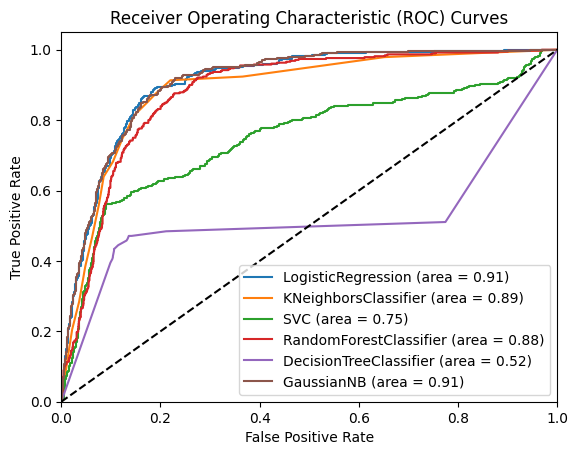

In [43]:
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, ConfusionMatrixDisplay  # Import f1_score
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

# Dictionary to store the best model and test accuracy for each algorithm
model_accuracy_info = {}

# Define the hyperparameter grid for each model
param_grid = {
    'LogisticRegression': {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'random_state': [42]},
    'KNeighborsClassifier': {'n_neighbors': [3, 5, 7, 10, 12, 13, 15, 20]},
    'SVC': {'C': [0.1, 1, 10], 'kernel': ['rbf', 'linear'], 'gamma': ['scale', 'auto'], 'random_state': [42], 'probability': [True]},
    'RandomForestClassifier': {'n_estimators': [10, 50, 100], 'max_depth': [None, 10, 20, 30], 'random_state': [42]},
    'DecisionTreeClassifier': {'max_depth': [None, 5, 10, 20], 'random_state': [42]},
    'GaussianNB': {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]}
}

# Initialize models
models = {
    'LogisticRegression': LogisticRegression(),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'SVC': SVC(),
    'RandomForestClassifier': RandomForestClassifier(),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'GaussianNB': GaussianNB(),
}

# Ignore convergence and future warnings
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)
simplefilter("ignore", category=FutureWarning)

# Function to manually tune hyperparameters
def tune_hyperparameters(model, params, X_train, y_train, X_val, y_val):
    best_model = None
    best_params = {}
    best_auc = 0  # Use AUC-ROC instead of F1 score
    for param in ParameterGrid(params):
        model.set_params(**param)
        model.fit(X_train, y_train)
        probabilities = model.predict_proba(X_val)
        auc = roc_auc_score(y_val, probabilities[:, 1])  # Calculate AUC-ROC
        if auc > best_auc:
            best_auc = auc
            best_model = model
            best_params = param
    return best_model, best_params

# Perform hyperparameter tuning and evaluation
for name, model in models.items():
    print(f"Model: {name}")
    if name in param_grid:
        # Tune hyperparameters
        best_model, best_params = tune_hyperparameters(model, param_grid[name], X_train, y_train, X_val, y_val)
        print(f"Best parameters for {name}: {best_params}")
        model = best_model

    # Predict and evaluate on test data using AUC-ROC
    pred_test = model.predict_proba(X_test)
    auc_test = roc_auc_score(y_test, pred_test[:, 1])  # Calculate AUC-ROC
    accuracy_test = accuracy_score(y_test, pred_test[:, 1] >= 0.5)  # Calculate accuracy

    print(f"Test AUC-ROC for {name}: {auc_test:.4f}\n")
    model_filename = f"{name}_model_V2.joblib"
    joblib.dump(model, model_filename)
    model_accuracy_info[name] = {
        'model': model_filename,
        'auc_roc': auc_test,  # Store AUC-ROC
        'accuracy': accuracy_test
    }

    # Calculate ROC curve and AUC for each model
    fpr, tpr, thresholds = roc_curve(y_test, pred_test[:, 1])
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.plot(fpr, tpr, label=f'{name} (area = {roc_auc:.2f})')

    # Print model and F1 score info
for model_name, info in model_accuracy_info.items():
    print(f"Model: {model_name}, File: {info['model']}, Test AUC-ROC: {info['auc_roc']:.4f}, Test Accuracy: {info['accuracy']:.4f}")

plt.plot([0, 1], [0, 1], 'k--')  # Add a diagonal dashed line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()

### Experiement 3: Now we add four more features: average finishing position of drivers and constructors last year, average finishing positions of drivers and constructors this year up till last race.

#### Model Training and Assessment

In [44]:
df_3 = df_final_encoded.drop(["grid"], axis = 1)

In [ ]:
df_3

In [45]:
from sklearn.preprocessing import StandardScaler

train_df = df_3[(df_3["year"] >= 1983) & (df_3["year"] <= 2008)]   # getting the the data from 1983 to 2008 as the training data
val_df = df_3[(df_3["year"] >= 2009) & (df_3["year"] <= 2016)]   # getting the the data from 1983 to 2008 as the validation data
test_df = df_3[(df_3["year"] >= 2017) & (df_3["year"] <= 2023)]  # getting the the data from 1983 to 2008 as the Testing data

# ---------------  TRAINING DATA  ----------------------
X_train = train_df[train_df.columns.tolist()[:-1]].values  #excluding the Last column
y_train = train_df['Top 3 Finish'].values  # The last column is Top3 Finish

# ---------------  Validation DATA  ----------------------
X_val = val_df[train_df.columns.tolist()[:-1]].values
y_val = val_df['Top 3 Finish'].values


# ---------------  Test DATA  ----------------------
X_test = test_df[train_df.columns.tolist()[:-1]].values
y_test = test_df['Top 3 Finish'].values

Model: LogisticRegression
Best parameters for LogisticRegression: {'C': 100, 'random_state': 42}
Test AUC-ROC for LogisticRegression: 0.9076

Model: KNeighborsClassifier
Best parameters for KNeighborsClassifier: {'n_neighbors': 20}
Test AUC-ROC for KNeighborsClassifier: 0.8873

Model: SVC
Best parameters for SVC: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf', 'probability': True, 'random_state': 42}
Test AUC-ROC for SVC: 0.8292

Model: RandomForestClassifier
Best parameters for RandomForestClassifier: {'max_depth': 10, 'n_estimators': 100, 'random_state': 42}
Test AUC-ROC for RandomForestClassifier: 0.8968

Model: DecisionTreeClassifier
Best parameters for DecisionTreeClassifier: {'max_depth': 5, 'random_state': 42}
Test AUC-ROC for DecisionTreeClassifier: 0.5378

Model: GaussianNB
Best parameters for GaussianNB: {'var_smoothing': 0.01}
Test AUC-ROC for GaussianNB: 0.9101

Model: LogisticRegression, File: LogisticRegression_model_V3.joblib, Test AUC-ROC: 0.9076, Test Accuracy: 0.8679
Mo

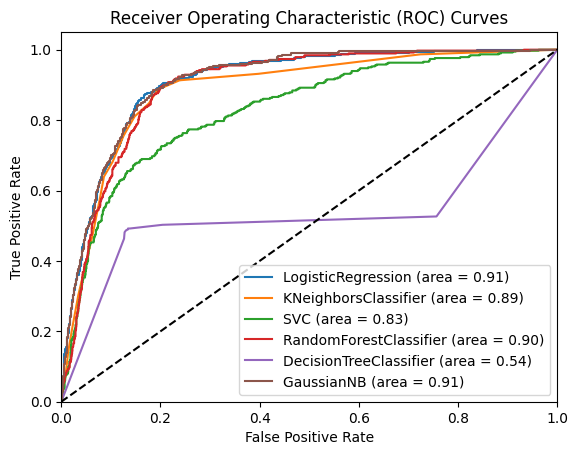

In [46]:
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, ConfusionMatrixDisplay  # Import f1_score
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

# Dictionary to store the best model and test accuracy for each algorithm
model_accuracy_info = {}

# Define the hyperparameter grid for each model
param_grid = {
    'LogisticRegression': {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'random_state': [42]},
    'KNeighborsClassifier': {'n_neighbors': [3, 5, 7, 10, 12, 13, 15, 20]},
    'SVC': {'C': [0.1, 1, 10], 'kernel': ['rbf', 'linear'], 'gamma': ['scale', 'auto'], 'random_state': [42], 'probability': [True]},
    'RandomForestClassifier': {'n_estimators': [10, 50, 100], 'max_depth': [None, 10, 20, 30], 'random_state': [42]},
    'DecisionTreeClassifier': {'max_depth': [None, 5, 10, 20], 'random_state': [42]},
    'GaussianNB': {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]}
}

# Initialize models
models = {
    'LogisticRegression': LogisticRegression(),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'SVC': SVC(),
    'RandomForestClassifier': RandomForestClassifier(),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'GaussianNB': GaussianNB(),
}

# Ignore convergence and future warnings
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)
simplefilter("ignore", category=FutureWarning)

# Function to manually tune hyperparameters
def tune_hyperparameters(model, params, X_train, y_train, X_val, y_val):
    best_model = None
    best_params = {}
    best_auc = 0  # Use AUC-ROC instead of F1 score
    for param in ParameterGrid(params):
        model.set_params(**param)
        model.fit(X_train, y_train)
        probabilities = model.predict_proba(X_val)
        auc = roc_auc_score(y_val, probabilities[:, 1])  # Calculate AUC-ROC
        if auc > best_auc:
            best_auc = auc
            best_model = model
            best_params = param
    return best_model, best_params

# Perform hyperparameter tuning and evaluation
for name, model in models.items():
    print(f"Model: {name}")
    if name in param_grid:
        # Tune hyperparameters
        best_model, best_params = tune_hyperparameters(model, param_grid[name], X_train, y_train, X_val, y_val)
        print(f"Best parameters for {name}: {best_params}")
        model = best_model

    # Predict and evaluate on test data using AUC-ROC
    pred_test = model.predict_proba(X_test)
    auc_test = roc_auc_score(y_test, pred_test[:, 1])  # Calculate AUC-ROC
    accuracy_test = accuracy_score(y_test, pred_test[:, 1] >= 0.5)  # Calculate accuracy

    print(f"Test AUC-ROC for {name}: {auc_test:.4f}\n")
    model_filename = f"{name}_model_V3.joblib"
    joblib.dump(model, model_filename)
    model_accuracy_info[name] = {
        'model': model_filename,
        'auc_roc': auc_test,  # Store AUC-ROC
        'accuracy': accuracy_test
    }

    # Calculate ROC curve and AUC for each model
    fpr, tpr, thresholds = roc_curve(y_test, pred_test[:, 1])
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.plot(fpr, tpr, label=f'{name} (area = {roc_auc:.2f})')

    # Print model and F1 score info
for model_name, info in model_accuracy_info.items():
    print(f"Model: {model_name}, File: {info['model']}, Test AUC-ROC: {info['auc_roc']:.4f}, Test Accuracy: {info['accuracy']:.4f}")

plt.plot([0, 1], [0, 1], 'k--')  # Add a diagonal dashed line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()

## Predicting F1 podiums with qualfying data

Qualifying results are determined by the fastest lap achieved by the drivers. Faster drivers start the race in front.

Using features in Experiment 3, but adding starting grid position (determined by qualifying result)


#### Model Training and Assessment

In [47]:
df_with_qualifying = df_final_encoded

In [48]:
from sklearn.preprocessing import StandardScaler

train_df = df_with_qualifying[(df_with_qualifying["year"] >= 1983) & (df_with_qualifying["year"] <= 2008)]
val_df = df_with_qualifying[(df_with_qualifying["year"] >= 2009) & (df_with_qualifying["year"] <= 2016)]
test_df = df_with_qualifying[(df_with_qualifying["year"] >= 2017) & (df_with_qualifying["year"] <= 2023)]

X_train = train_df[train_df.columns.tolist()[:-1]].values
y_train = train_df['Top 3 Finish'].values
X_val = val_df[train_df.columns.tolist()[:-1]].values
y_val = val_df['Top 3 Finish'].values
X_test = test_df[train_df.columns.tolist()[:-1]].values
y_test = test_df['Top 3 Finish'].values

Model: LogisticRegression
Best parameters for LogisticRegression: {'C': 0.1, 'random_state': 42}
Test AUC-ROC for LogisticRegression: 0.9252

Model: KNeighborsClassifier
Best parameters for KNeighborsClassifier: {'n_neighbors': 20}
Test AUC-ROC for KNeighborsClassifier: 0.8937

Model: SVC
Best parameters for SVC: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear', 'probability': True, 'random_state': 42}
Test AUC-ROC for SVC: 0.8943

Model: RandomForestClassifier
Best parameters for RandomForestClassifier: {'max_depth': 10, 'n_estimators': 50, 'random_state': 42}
Test AUC-ROC for RandomForestClassifier: 0.9258

Model: DecisionTreeClassifier
Best parameters for DecisionTreeClassifier: {'max_depth': 5, 'random_state': 42}
Test AUC-ROC for DecisionTreeClassifier: 0.7252

Model: GaussianNB
Best parameters for GaussianNB: {'var_smoothing': 0.001}
Test AUC-ROC for GaussianNB: 0.9152

Model: LogisticRegression, File: LogisticRegression_model_V4.joblib, Test AUC-ROC: 0.9252, Test Accuracy: 0.8800

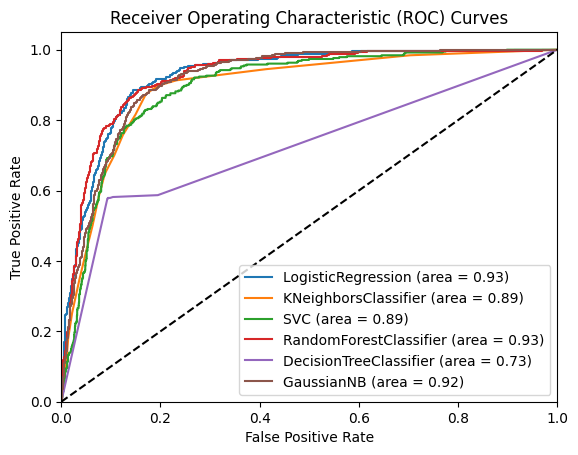

In [49]:
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

# Dictionary to store the best model and test accuracy for each algorithm
model_accuracy_info = {}

# Define the hyperparameter grid for each model
param_grid = {
    'LogisticRegression': {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'random_state': [42]},
    'KNeighborsClassifier': {'n_neighbors': [3, 5, 7, 10, 12, 13, 15, 20]},
    'SVC': {'C': [0.1, 1, 10], 'kernel': ['rbf', 'linear'], 'gamma': ['scale', 'auto'], 'random_state': [42], 'probability': [True]},
    'RandomForestClassifier': {'n_estimators': [10, 50, 100], 'max_depth': [None, 10, 20, 30], 'random_state': [42]},
    'DecisionTreeClassifier': {'max_depth': [None, 5, 10, 20], 'random_state': [42]},
    'GaussianNB': {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]}
}

# Initialize models
models = {
    'LogisticRegression': LogisticRegression(),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'SVC': SVC(),
    'RandomForestClassifier': RandomForestClassifier(),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'GaussianNB': GaussianNB(),
}

# Ignore convergence and future warnings
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)
simplefilter("ignore", category=FutureWarning)

# Function to manually tune hyperparameters
def tune_hyperparameters(model, params, X_train, y_train, X_val, y_val):
    best_model = None
    best_params = {}
    best_auc = 0  # Use AUC-ROC instead of F1 score
    for param in ParameterGrid(params):
        model.set_params(**param)
        model.fit(X_train, y_train)
        probabilities = model.predict_proba(X_val)
        auc = roc_auc_score(y_val, probabilities[:, 1])  # Calculate AUC-ROC
        if auc > best_auc:
            best_auc = auc
            best_model = model
            best_params = param
    return best_model, best_params

# Perform hyperparameter tuning and evaluation
for name, model in models.items():
    print(f"Model: {name}")
    if name in param_grid:
        # Tune hyperparameters
        best_model, best_params = tune_hyperparameters(model, param_grid[name], X_train, y_train, X_val, y_val)
        print(f"Best parameters for {name}: {best_params}")
        model = best_model

    # Predict and evaluate on test data using AUC-ROC
    pred_test = model.predict_proba(X_test)
    auc_test = roc_auc_score(y_test, pred_test[:, 1])  # Calculate AUC-ROC
    accuracy_test = accuracy_score(y_test, pred_test[:, 1] >= 0.5)  # Calculate accuracy

    print(f"Test AUC-ROC for {name}: {auc_test:.4f}\n")
    model_filename = f"{name}_model_V4.joblib"
    joblib.dump(model, model_filename)
    model_accuracy_info[name] = {
        'model': model_filename,
        'auc_roc': auc_test,  # Store AUC-ROC
        'accuracy': accuracy_test
    }

    # Calculate ROC curve and AUC for each model
    fpr, tpr, thresholds = roc_curve(y_test, pred_test[:, 1])
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.plot(fpr, tpr, label=f'{name} (area = {roc_auc:.2f})')

    # Print model and F1 score info
for model_name, info in model_accuracy_info.items():
    print(f"Model: {model_name}, File: {info['model']}, Test AUC-ROC: {info['auc_roc']:.4f}, Test Accuracy: {info['accuracy']:.4f}")

plt.plot([0, 1], [0, 1], 'k--')  # Add a diagonal dashed line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()


Random Forest Classifier ('max depth' = 10 and 'number of estimators' = 50) is our best model based on ROC-AUC score

#### Model Interpretation

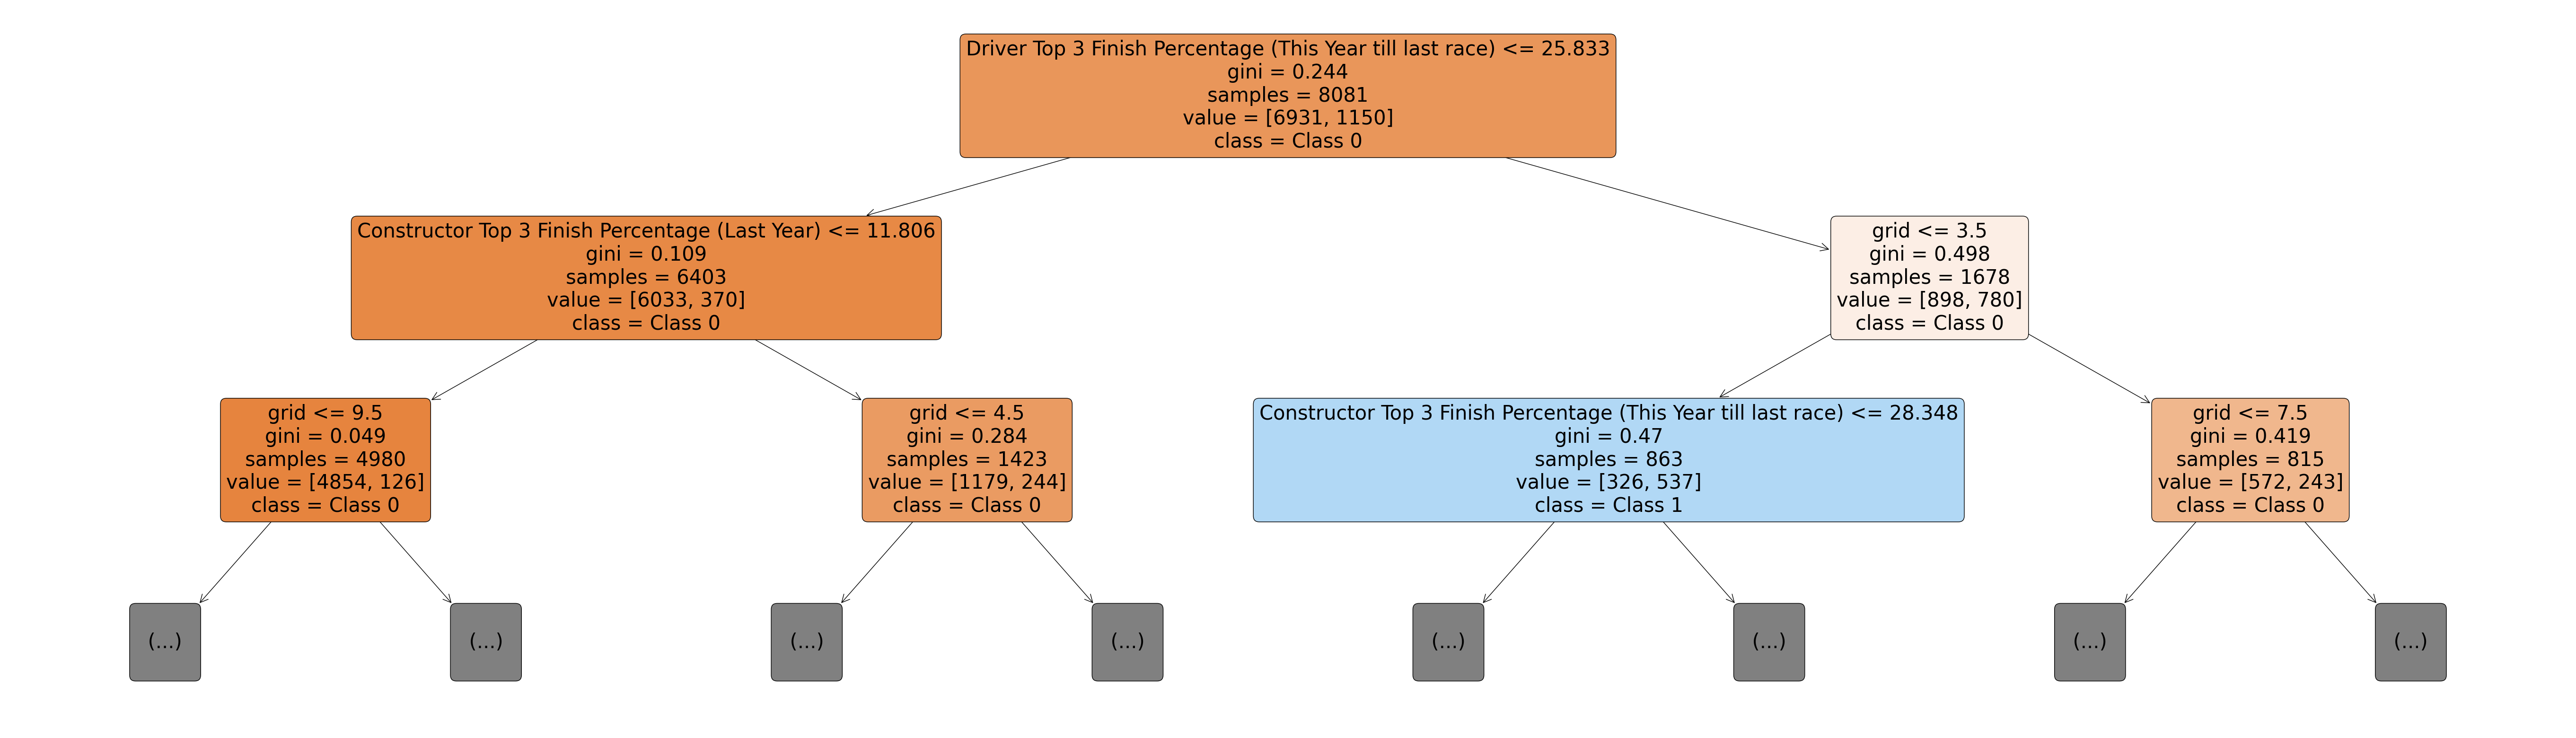

                                              Feature  Importance
5   Driver Top 3 Finish Percentage (This Year till...    0.273399
2                                                grid    0.115633
9   Driver Average Position (This Year till last r...    0.077467
10  Constructor Average Position (This Year till l...    0.072820
6   Constructor Top 3 Finish Percentage (This Year...    0.057756
1                                               round    0.050853
4     Constructor Top 3 Finish Percentage (Last Year)    0.047887
7                     Driver Avg position (Last Year)    0.027598
0                                                year    0.024988
3          Driver Top 3 Finish Percentage (Last Year)    0.022515


In [50]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Define the maximum depth to display
max_depth = 2 # Adjust this value to control the number of levels shown

dt_model = joblib.load("DecisionTreeClassifier_model_V4.joblib")

# Set the size of the plot
plt.figure(figsize=(70, 20))

# Plot the tree with maximum depth
plot_tree(dt_model,
          max_depth=max_depth,
          filled=True,
          rounded=True,
          class_names=['Class 0', 'Class 1'],
          feature_names=train_df.columns,
          fontsize = 30)

# Show the plot
plt.show()

dt_feature_importances = dt_model.feature_importances_

# Create a DataFrame from the feature names and their importances
dt_importances_df = pd.DataFrame({
    'Feature': train_df.columns[:-1],  # Ensure this matches your feature set
    'Importance': dt_feature_importances
})

# Sort the DataFrame by the importances
dt_importances_df.sort_values(by='Importance', ascending=False, inplace=True)

# Print the sorted DataFrame
print(dt_importances_df.head(10))


In [51]:
# Random Forest Classifier
from joblib import load
model = load("RandomForestClassifier_model_V4.joblib")
importances = model.feature_importances_

# Create a DataFrame for visualization
importances_df = pd.DataFrame({'Feature': df_with_qualifying.columns[:-1], 'Importance': importances})

# Sort the DataFrame
importances_df.sort_values(by='Importance', ascending=False, inplace=True)

# Display the feature importances
print(importances_df.head(10))

print(model.get_params(deep = True))

                                              Feature  Importance
2                                                grid    0.113024
5   Driver Top 3 Finish Percentage (This Year till...    0.097392
9   Driver Average Position (This Year till last r...    0.085568
6   Constructor Top 3 Finish Percentage (This Year...    0.081203
10  Constructor Average Position (This Year till l...    0.073770
3          Driver Top 3 Finish Percentage (Last Year)    0.059293
4     Constructor Top 3 Finish Percentage (Last Year)    0.059269
1                                               round    0.050862
7                     Driver Avg position (Last Year)    0.047299
8                Constructor Avg position (Last Year)    0.040191
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 30, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.

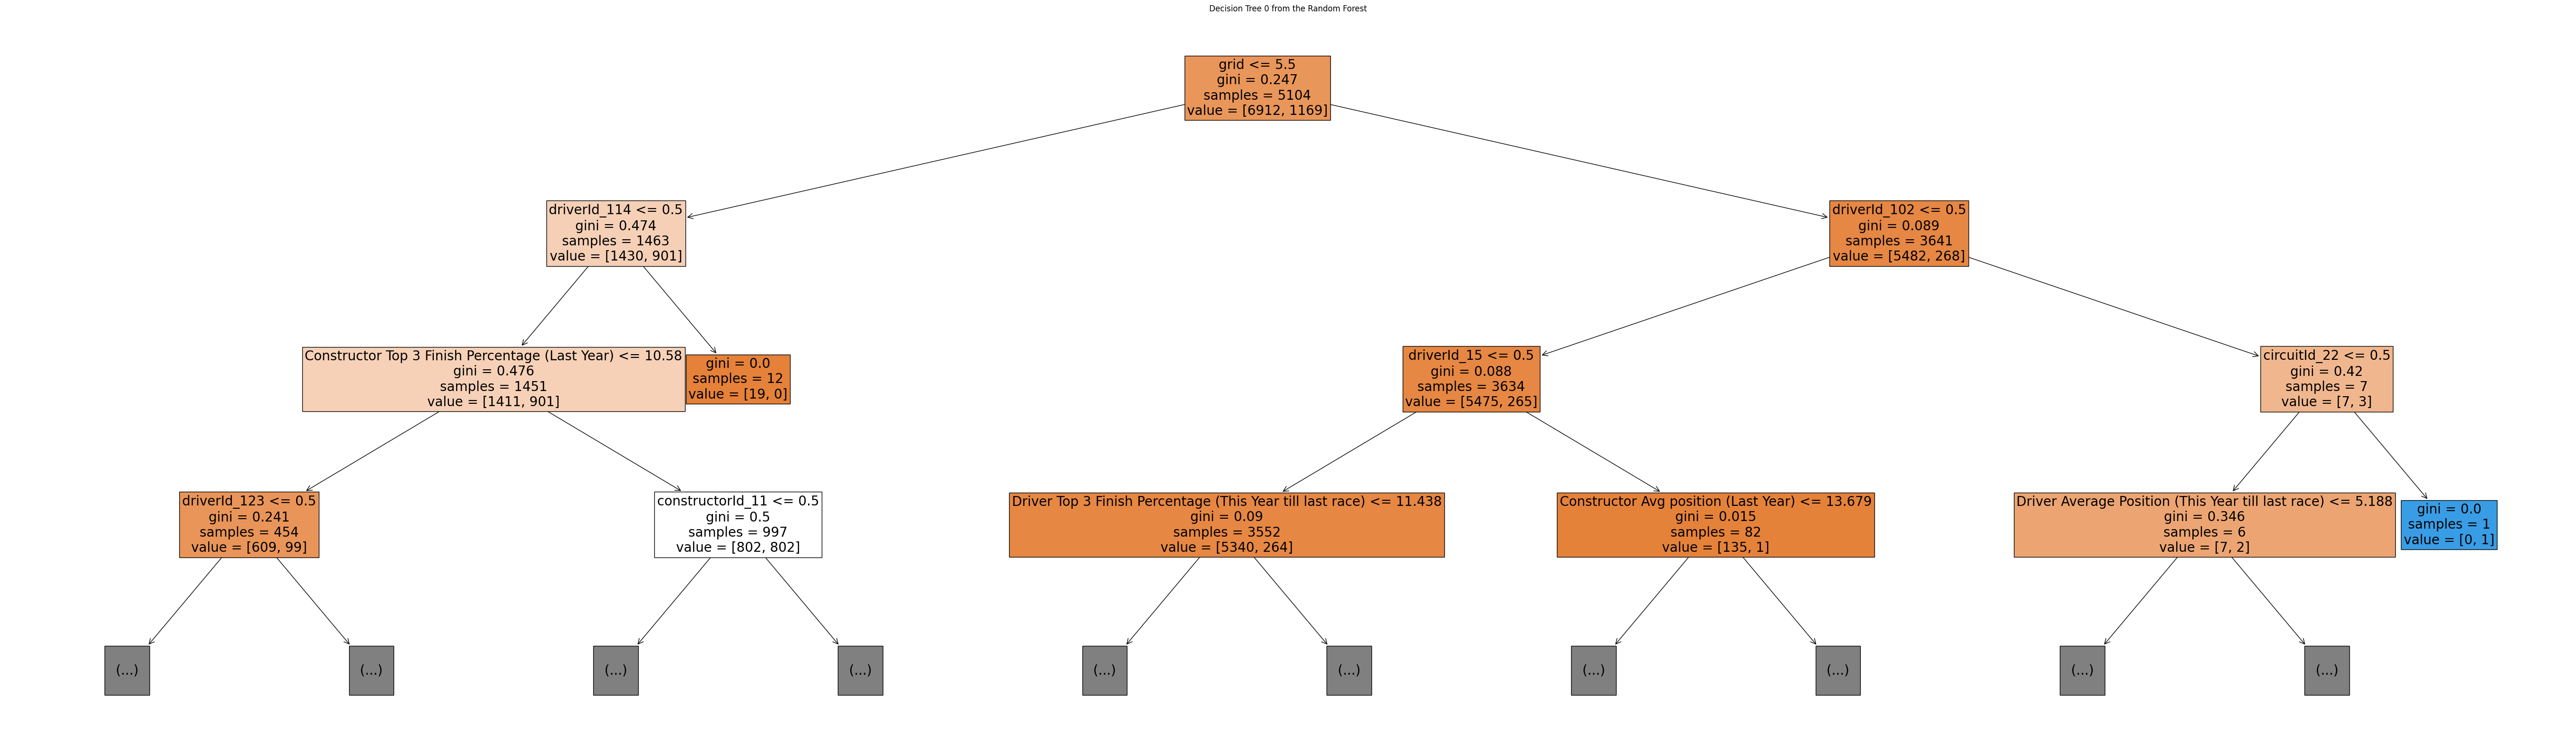

In [52]:
from sklearn import tree
single_tree = model.estimators_[0]

# Visualization
plt.figure(figsize=(70,20))  # Adjust the size as needed
tree.plot_tree(single_tree, filled=True, feature_names=df_with_qualifying.columns[:-1], max_depth=3, fontsize = 20)
plt.title("Decision Tree 0 from the Random Forest")
plt.show()

### Changing thresholds for models and Model Prediction
We want to fine tune our best model Random Forest Classifier ('max depth' = 10 and 'number of estimators' = 50) by adjusting decision thresholds to balance the tradeoff between true positive and false positive rates. Since both recall and precision are important evaluation metrics for our use case, we optimized the F1 score (harmonic mean of Recall and Precision) to determine the best threshold.

Optimal Threshold for F1 Score: 0.369


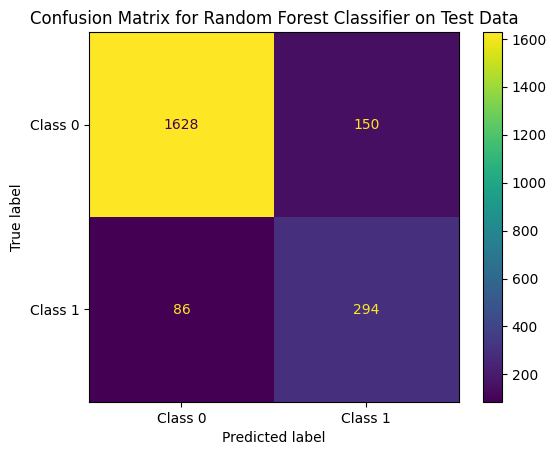

Accuracy of the model: 0.891
F1 Score of the model: 0.714


['RandomForestClassifier_model_V4_with_threshold.joblib']

In [53]:
from sklearn.metrics import precision_recall_curve, f1_score
# Load the model
model = load("RandomForestClassifier_model_V4.joblib")

# Predict probabilities on new data
data_prob = model.predict_proba(X_test)[:, 1]

# Compute Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(y_test, data_prob)
f1_scores = 2 * recall * precision / (recall + precision + 1e-10)

# Find the optimal threshold
optimal_idx = np.nanargmax(f1_scores)  # Using nanargmax to ignore NaN values
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold for F1 Score: {optimal_threshold:.3f}")

# Apply the new threshold to make class predictions
pred_test = (data_prob >= optimal_threshold).astype(int)

# Display the Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, pred_test, display_labels=['Class 0', 'Class 1'])
plt.title("Confusion Matrix for Random Forest Classifier on Test Data")
plt.show()

# Calculate and print the accuracy
accuracy = accuracy_score(y_test, pred_test)
print(f"Accuracy of the model: {accuracy:.3f}")

# Calculate and print the F1 score
f1 = f1_score(y_test, pred_test)
print(f"F1 Score of the model: {f1:.3f}")

# Create a dictionary to hold the model and the threshold
model_data = {
    "model": model,
    "threshold": optimal_threshold
}

# Save the dictionary
model_filename = "RandomForestClassifier_model_V4_with_threshold.joblib"
joblib.dump(model_data, model_filename)

We also tried the same thing for our second best model logistic regression (C = 10)

Optimal Threshold for F1 Score: 0.346


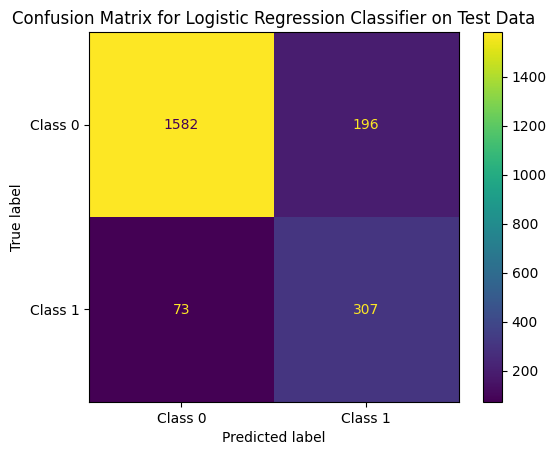

Accuracy of the model: 0.875
F1 Score of the model: 0.695


['LogisticRegression_model_V4_with_threshold.joblib']

In [54]:
model = load("LogisticRegression_model_V4.joblib")

# Predict probabilities on new data
data_prob = model.predict_proba(X_test)[:, 1]

# Compute Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(y_test, data_prob)
f1_scores = 2 * recall * precision / (recall + precision + 1e-10)

# Find the optimal threshold
optimal_idx = np.nanargmax(f1_scores)  # Using nanargmax to ignore NaN values
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold for F1 Score: {optimal_threshold:.3f}")

# Apply the new threshold to make class predictions
pred_test = (data_prob >= optimal_threshold).astype(int)

# Display the Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, pred_test, display_labels=['Class 0', 'Class 1'])
plt.title("Confusion Matrix for Logistic Regression Classifier on Test Data")
plt.show()

# Calculate and print the accuracy
accuracy = accuracy_score(y_test, pred_test)
print(f"Accuracy of the model: {accuracy:.3f}")

# Calculate and print the F1 score
f1 = f1_score(y_test, pred_test)
print(f"F1 Score of the model: {f1:.3f}")

# Create a dictionary to hold the model and the threshold
model_data = {
    "model": model,
    "threshold": optimal_threshold
}

# Save the dictionary
model_filename = "LogisticRegression_model_V4_with_threshold.joblib"
joblib.dump(model_data, model_filename)

Based on F1 score, our final chosen model to predict whether a driver is likely to finish in top 3 in a given race is therefore a Random Forest Classifier ('max depth' = 10 and 'number of estimators' = 50) with a custom decision threshold of 0.369

### F1 podium prediction example: 2023 Spanish Grand Prix (Round 7)

In [55]:
from joblib import load
import pandas as pd

round = 7

# Load the model and threshold
model_data = load("RandomForestClassifier_model_V4_with_threshold.joblib")
model = model_data["model"]
optimal_threshold = model_data["threshold"]

# Filter the DataFrame for the year 2023 and round 7 (Spanish Grand Prix)
df_2023 = df_with_qualifying[(df_with_qualifying["year"] == 2023) & (df_with_qualifying["round"] == round)]

# Prepare the feature matrix for prediction
X_2023 = df_2023[df_2023.columns.tolist()[:-1]].values

# Compute probabilities using the model
probabilities = model.predict_proba(X_2023)

# Apply the threshold to make class predictions
pred_test = (probabilities[:, 1] >= optimal_threshold).astype(int)  # Assuming the second column represents the probability of top 3 finish

# Selecting relevant columns and filtering for year 2023 and round 7
df_predict2023 = df_final[["year", "round", "driverId", "constructorId", "grid", "Top 3 Finish"]]
df_predict2023 = df_predict2023[(df_predict2023["year"] == 2023) & (df_predict2023["round"] == round)]



# Create a dictionary to map 'driverId' to 'surname'
driver_name_dict = pd.Series(drivers_df.surname.values, index=drivers_df.driverId).to_dict()

# Replace 'driverId' with corresponding 'surname' in df_predict2023
df_predict2023['driverId'] = df_predict2023['driverId'].map(driver_name_dict)

# Append the predictions to the DataFrame
df_predict2023['Top_3_Finish_Prediction'] = pred_test


# Create a dictionary to map 'constructorId' to 'name'
constructor_name_dict = pd.Series(constructors_df.name.values, index=constructors_df.constructorId).to_dict()

# Replace 'constructorId' with corresponding 'name' in df_predict2023
df_predict2023['constructorId'] = df_predict2023['constructorId'].map(constructor_name_dict)

# Append the predictions to the DataFrame
df_predict2023['Top_3_Finish_Prediction'] = pred_test


# Print the DataFrame with predictions
print(df_predict2023)


       year  round    driverId   constructorId  grid  Top 3 Finish  \
17201  2023      7  Verstappen        Red Bull     1             1   
17202  2023      7    Hamilton        Mercedes     4             1   
17203  2023      7     Russell        Mercedes    12             1   
17204  2023      7       Pérez        Red Bull    11             0   
17205  2023      7       Sainz         Ferrari     2             0   
17206  2023      7      Stroll    Aston Martin     5             0   
17207  2023      7      Alonso    Aston Martin     8             0   
17208  2023      7        Ocon  Alpine F1 Team     6             0   
17209  2023      7        Zhou      Alfa Romeo    13             0   
17210  2023      7       Gasly  Alpine F1 Team    10             0   
17211  2023      7     Leclerc         Ferrari    19             0   
17212  2023      7     Tsunoda      AlphaTauri    15             0   
17214  2023      7    de Vries      AlphaTauri    14             0   
17215  2023      7  

In [56]:
model = load("LogisticRegression_model_V4.joblib")

df_2023 = df_with_qualifying[(df_with_qualifying["year"] == 2023) & (df_with_qualifying["round"] == 5)]
X_2023 = df_2023[df_2023.columns.tolist()[:-1]].values
print(df_2023)
probabilities = model.predict_proba(X_2023)
print(probabilities)

       year  round  grid  Driver Top 3 Finish Percentage (Last Year)  \
17161  2023      5     9                                   77.272727   
17162  2023      5     1                                   50.000000   
17163  2023      5     2                                    0.000000   
17164  2023      5     6                                   36.363636   
17165  2023      5     3                                   40.909091   
17166  2023      5    13                                   40.909091   
17167  2023      5     7                                   50.000000   
17168  2023      5     5                                    0.000000   
17169  2023      5     8                                    0.000000   
17170  2023      5     4                                    0.000000   
17171  2023      5    17                                    0.000000   
17172  2023      5    18                                    0.000000   
17173  2023      5    10                                    0.00

## Predicting F1 podiums with qualfying data (Oversampling)

Now we try to oversample minority class (Class 1) to see if we can do even better

#### Model Training and Assessment

In [57]:
df_with_qualifying = df_final_encoded

In [58]:
from sklearn.preprocessing import StandardScaler

train_df = df_with_qualifying[(df_with_qualifying["year"] >= 1983) & (df_with_qualifying["year"] <= 2008)]
val_df = df_with_qualifying[(df_with_qualifying["year"] >= 2009) & (df_with_qualifying["year"] <= 2016)]
test_df = df_with_qualifying[(df_with_qualifying["year"] >= 2017) & (df_with_qualifying["year"] <= 2023)]

X_train = train_df[train_df.columns.tolist()[:-1]].values
y_train = train_df['Top 3 Finish'].values
X_val = val_df[train_df.columns.tolist()[:-1]].values
y_val = val_df['Top 3 Finish'].values
X_test = test_df[train_df.columns.tolist()[:-1]].values
y_test = test_df['Top 3 Finish'].values

print(X_train)
print(y_train)

[[1983 2 22 ... False False False]
 [1983 2 23 ... False False False]
 [1983 2 2 ... False False False]
 ...
 [2008 18 16 ... False False False]
 [2008 18 19 ... False False False]
 [2008 18 14 ... False False False]]
[1 1 1 ... 0 0 0]


In [59]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

# Initialize the RandomOverSampler
ros = RandomOverSampler(random_state=42)

# Fit and apply the transform
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# Summarize class distribution
print("Before oversampling: ", Counter(y_train))
print("After oversampling: ", Counter(y_train_resampled))

Before oversampling:  Counter({0: 6931, 1: 1150})
After oversampling:  Counter({1: 6931, 0: 6931})


Model: LogisticRegression
Best parameters for LogisticRegression: {'C': 0.01, 'random_state': 42}
Test AUC-ROC for LogisticRegression: 0.9249

Model: RandomForestClassifier
Best parameters for RandomForestClassifier: {'max_depth': 20, 'n_estimators': 100, 'random_state': 42}
Test AUC-ROC for RandomForestClassifier: 0.9193

Model: LogisticRegression, File: LogisticRegression_model_V5.joblib, Test AUC-ROC: 0.9249, Test Accuracy: 0.8049
Model: RandomForestClassifier, File: RandomForestClassifier_model_V5.joblib, Test AUC-ROC: 0.9193, Test Accuracy: 0.8842


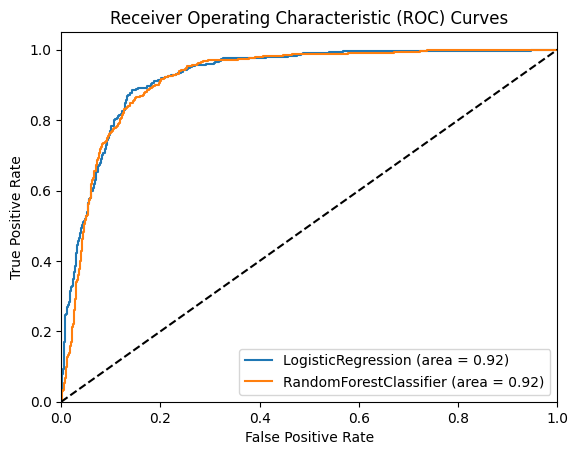

In [60]:
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, ConfusionMatrixDisplay  # Import f1_score
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

# Dictionary to store the best model and test accuracy for each algorithm
model_accuracy_info = {}

# Define the hyperparameter grid for each model
param_grid = {
    'LogisticRegression': {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'random_state': [42]},
    'RandomForestClassifier': {'n_estimators': [10, 50, 100], 'max_depth': [None, 10, 20, 30], 'random_state': [42]}
}

# Initialize models
models = {
    'LogisticRegression': LogisticRegression(),
    'RandomForestClassifier': RandomForestClassifier()
}

# Ignore convergence and future warnings
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)
simplefilter("ignore", category=FutureWarning)

# Function to manually tune hyperparameters
def tune_hyperparameters(model, params, X_train_resampled, y_train_resampled, X_val, y_val):
    best_model = None
    best_params = {}
    best_auc = 0  # Use AUC-ROC instead of F1 score
    for param in ParameterGrid(params):
        model.set_params(**param)
        model.fit(X_train_resampled, y_train_resampled)
        probabilities = model.predict_proba(X_val)
        auc = roc_auc_score(y_val, probabilities[:, 1])  # Calculate AUC-ROC
        if auc > best_auc:
            best_auc = auc
            best_model = model
            best_params = param
    return best_model, best_params

# Perform hyperparameter tuning and evaluation
for name, model in models.items():
    print(f"Model: {name}")
    if name in param_grid:
        # Tune hyperparameters
        best_model, best_params = tune_hyperparameters(model, param_grid[name], X_train_resampled, y_train_resampled, X_val, y_val)
        print(f"Best parameters for {name}: {best_params}")
        model = best_model

    # Predict and evaluate on test data using AUC-ROC
    pred_test = model.predict_proba(X_test)
    auc_test = roc_auc_score(y_test, pred_test[:, 1])  # Calculate AUC-ROC
    accuracy_test = accuracy_score(y_test, pred_test[:, 1] >= 0.5)  # Calculate accuracy

    print(f"Test AUC-ROC for {name}: {auc_test:.4f}\n")
    model_filename = f"{name}_model_V5.joblib"
    joblib.dump(model, model_filename)
    model_accuracy_info[name] = {
        'model': model_filename,
        'auc_roc': auc_test,  # Store AUC-ROC
        'accuracy': accuracy_test
    }

    # Calculate ROC curve and AUC for each model
    fpr, tpr, thresholds = roc_curve(y_test, pred_test[:, 1])
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.plot(fpr, tpr, label=f'{name} (area = {roc_auc:.2f})')

    # Print model and F1 score info
for model_name, info in model_accuracy_info.items():
    print(f"Model: {model_name}, File: {info['model']}, Test AUC-ROC: {info['auc_roc']:.4f}, Test Accuracy: {info['accuracy']:.4f}")

plt.plot([0, 1], [0, 1], 'k--')  # Add a diagonal dashed line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()


The ROC-AUC scores are lower than before, so we stick with the previous models we used.

# Predicting Finishing Position For every driver (only considers top 20 because the number of drivers each year is different)

For our second model, we want to predict each driver's exact finishing position in each race. Since the number of drivers are not the same in each year, we only consider the drivers in the top 20 for every race in our training and test sets. For each of these 20 drivers in every race, we want to classify his finishing position into 1 of 20 categories (1st, 2nd, ..., 20th). To determine the best possible model, we use cross entropy loss as a metric to evaluate how well the model's predicted probabilities align with the actual labels, guiding us in optimizing the model parameters for better accuracy and performance.

The features we used to train this model are the same as the ones we used to predict top 3 finishers. We selected a variety of models for this multiclass classification problem, including Logistic Regression, Random Forest, K-Nearest Neighbors, and Decision Tree.

In [61]:
print(df_final_keepPositionOrder)

       year  round  circuitId  driverId  constructorId  grid  positionOrder  \
493    1983      2         43       187              1    22              1   
494    1983      2         43       182              1    23              2   
495    1983      2         43       163              6     2              3   
496    1983      2         43       172              3     4              4   
497    1983      2         43       176             21    16              5   
...     ...    ...        ...       ...            ...   ...            ...   
17314  2023     12         13       848              3    15             14   
17315  2023     12         13       825            210    16             15   
17316  2023     12         13       817            213    19             16   
17318  2023     12         13       807            210     0             18   
17319  2023     12         13       832              6     4             19   

       Top 3 Finish  Driver Top 3 Finish Percentage

In [62]:
df_position = df_final_encoded
df_position.drop(["Top 3 Finish"], axis = 1, inplace=True)
# Check if both DataFrames have the same number of rows
if len(df_position) == len(df_final_keepPositionOrder):
    # Add 'positionOrder' column from df_final_keepPositionOrder to df_final
    df_position['positionOrder'] = df_final_keepPositionOrder['positionOrder']
else:
    print("The number of rows in df_final and df_final_keepPositionOrder does not match.")
print(df_position)

       year  round  grid  Driver Top 3 Finish Percentage (Last Year)  \
493    1983      2    22                                   33.333333   
494    1983      2    23                                   21.428571   
495    1983      2     2                                   25.000000   
496    1983      2     4                                    6.666667   
497    1983      2    16                                    0.000000   
...     ...    ...   ...                                         ...   
17314  2023     12    15                                    0.000000   
17315  2023     12    16                                    0.000000   
17316  2023     12    19                                    0.000000   
17318  2023     12     0                                    0.000000   
17319  2023     12     4                                   40.909091   

       Constructor Top 3 Finish Percentage (Last Year)  \
493                                          27.380952   
494                

In [63]:
df_top20 = df_position[df_position['positionOrder'] <= 20]

# Now split df_top20 into training, validation, and test sets as per your original year-based method
train_df = df_top20[(df_top20["year"] >= 1983) & (df_top20["year"] <= 2008)]
val_df = df_top20[(df_top20["year"] >= 2009) & (df_top20["year"] <= 2016)]
test_df = df_top20[(df_top20["year"] >= 2017) & (df_top20["year"] <= 2023)]

# Extract features and target variables
X_train = train_df.drop('positionOrder', axis=1)
y_train = train_df['positionOrder']
X_val = val_df.drop('positionOrder', axis=1)
y_val = val_df['positionOrder']
X_test = test_df.drop('positionOrder', axis=1)
y_test = test_df['positionOrder']


Model: LogisticRegression

Best parameters for LogisticRegression: {'C': 0.01, 'multi_class': 'multinomial', 'random_state': 42}
Test Log Loss for LogisticRegression: 2.7102
Test Accuracy for LogisticRegression: 0.1321


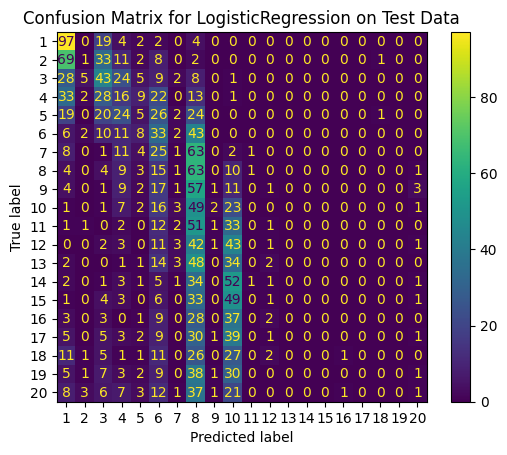





Model: RandomForestClassifier

Best parameters for RandomForestClassifier: {'max_depth': 10, 'n_estimators': 100, 'random_state': 42}
Test Log Loss for RandomForestClassifier: 2.8540
Test Accuracy for RandomForestClassifier: 0.1237


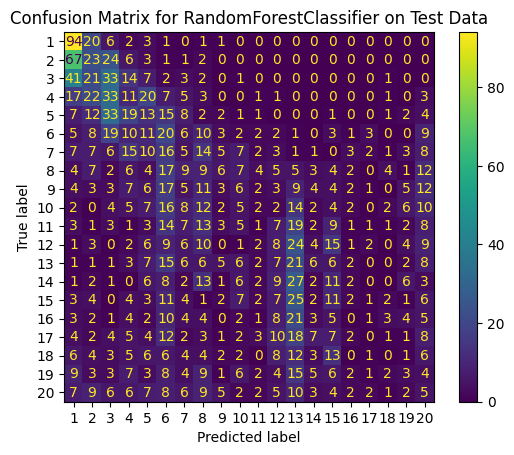





Model: KNeighborsClassifier

Best parameters for KNeighborsClassifier: {'metric': 'manhattan', 'n_neighbors': 10}
Test Log Loss for KNeighborsClassifier: 17.0486
Test Accuracy for KNeighborsClassifier: 0.1126


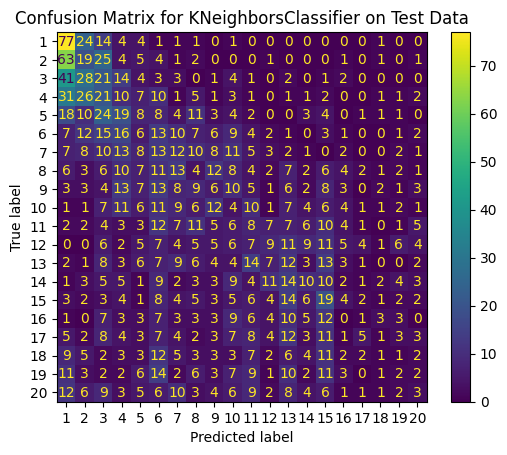





Model: DecisionTreeClassifier

Best parameters for DecisionTreeClassifier: {'max_depth': 5, 'random_state': 42}
Test Log Loss for DecisionTreeClassifier: 24.2882
Test Accuracy for DecisionTreeClassifier: 0.1112


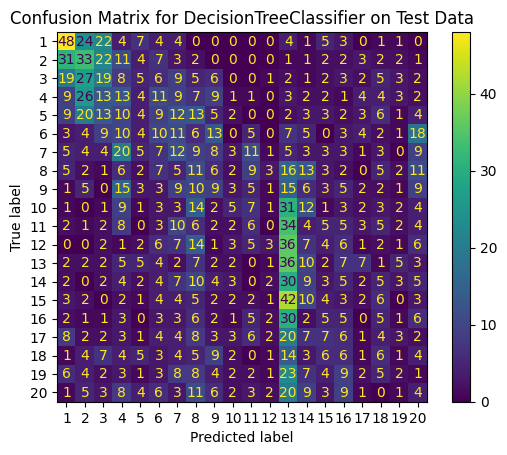





Model: LogisticRegression, File: LogisticRegression_model_multiClass.joblib, Test Log Loss: 2.7102, Test Accuracy: 0.1321
Model: RandomForestClassifier, File: RandomForestClassifier_model_multiClass.joblib, Test Log Loss: 2.8540, Test Accuracy: 0.1237
Model: KNeighborsClassifier, File: KNeighborsClassifier_model_multiClass.joblib, Test Log Loss: 17.0486, Test Accuracy: 0.1126
Model: DecisionTreeClassifier, File: DecisionTreeClassifier_model_multiClass.joblib, Test Log Loss: 24.2882, Test Accuracy: 0.1112


In [64]:
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import log_loss

# Dictionary to store the best model and test accuracy for each algorithm
model_accuracy_info = {}

param_grid = {
    'LogisticRegression': {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'random_state': [42], 'multi_class': ['multinomial']},
    'RandomForestClassifier': {'n_estimators': [10, 50, 100], 'max_depth': [None, 10, 20, 30], 'random_state': [42]},
    'KNeighborsClassifier': {'n_neighbors': [3, 5, 7, 10], 'metric': ['euclidean', 'manhattan']},
    'DecisionTreeClassifier': {'max_depth': [None, 5, 10, 15, 20], 'random_state': [42]}
}

# Initialize models
models = {
    'LogisticRegression': LogisticRegression(),
    'RandomForestClassifier': RandomForestClassifier(),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'DecisionTreeClassifier': DecisionTreeClassifier()
}

# Function to manually tune hyperparameters
def tune_hyperparameters(model, params, X_train, y_train, X_val, y_val):
    best_model = None
    best_params = {}
    best_log_loss = float('inf')
    for param in ParameterGrid(params):
        model.set_params(**param)
        model.fit(X_train, y_train)
        probabilities = model.predict_proba(X_val)
        log_loss_val = log_loss(y_val, probabilities)
        if log_loss_val < best_log_loss:
            best_log_loss = log_loss_val
            best_model = model
            best_params = param
    return best_model, best_params

# Perform hyperparameter tuning and evaluation
for name, model in models.items():
    print(f"Model: {name}\n")
    if name in param_grid:
        # Tune hyperparameters
        best_model, best_params = tune_hyperparameters(model, param_grid[name], X_train, y_train, X_val, y_val)
        print(f"Best parameters for {name}: {best_params}")
        model = best_model
    else:
        # Fit model with default parameters
        model.fit(X_train, y_train)

    # Predict and evaluate on test data
    pred_test = model.predict(X_test)
    probabilities_test = model.predict_proba(X_test)
    log_loss_test = log_loss(y_test, probabilities_test)
    accuracy_test = accuracy_score(y_test, pred_test)
    print(f"Test Log Loss for {name}: {log_loss_test:.4f}")
    print(f"Test Accuracy for {name}: {accuracy_test:.4f}")

    model_filename = f"{name}_model_multiClass.joblib"
    joblib.dump(model, model_filename)
    model_accuracy_info[name] = {
        'model': model_filename,
        'log_loss': log_loss_test,
        'accuracy': accuracy_test
    }

    # Display confusion matrix
    ConfusionMatrixDisplay.from_predictions(y_test, pred_test)
    plt.title(f"Confusion Matrix for {name} on Test Data")
    plt.show()
    print("\n\n\n")

# Print model and accuracy info
for model_name, info in model_accuracy_info.items():
    print(f"Model: {model_name}, File: {info['model']}, Test Log Loss: {info['log_loss']:.4f}, Test Accuracy: {info['accuracy']:.4f}")


Thank you for reading my noetebook!

[Link to my GitHub repository](https://github.com/Roger-Weng/Formula-1-Race-Prediction/blob/main/SML312FinalProject.ipynb)